# Plotting DE results
-  PCA plots of results
-  MA plots of results
- Heatmaps of vsd normalized data

In [ ]:
suppressPackageStartupMessages(library('ComplexHeatmap'))
library('ggpubr')
library('hexbin')
library('tidyverse')
library('gridExtra')
library('viridis')
library('matrixStats')
library('corrr')
library('ggcorrplot')
library('DESeq2')
library('factoextra')
library('circlize')
library('RCurl')
library('ggtern')
library('ggfortify')
library('magick')
library('PCAtools')
library('multipanelfigure')
library('magrittr')
library('cowplot')

Loading required package: ggplot2

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package

## 1. Read in data
read in vsd normalized data and log fold change data for all data and kegg-summerized counts each. ko-definition table, ko-orf table and sub categories-definition table. 

In [2]:
#lfcShrink data
## 04:
lfc4.AvL <- read.csv("./de_res_files/lfc4.AvL.csv")
lfc4.k.AvL <- read.csv("./de_res_files/lfc4.AvL.kegg.csv")

## 08:
lfc8.AvL <- read.csv("./de_res_files/lfc8.AvL.csv")
lfc8.HvL <- read.csv("./de_res_files/lfc8.HvL.csv")

lfc8.k.AvL <- read.csv("./de_res_files/lfc8.AvL.kegg.csv")
lfc8.k.HvL <- read.csv("./de_res_files/lfc8.HvL.kegg.csv")

AvL.k8 = read.csv('./de_res_files/AvL8.k.csv')
## 06:
lfc6.AvL <- read.csv("./de_res_files/lfc6.AvL.csv")
lfc6.HvL <- read.csv("./de_res_files/lfc6.HvL.csv")

lfc6.k.AvL <- read.csv("./de_res_files/lfc6.AvL.kegg.csv")
lfc6.k.HvL <- read.csv("./de_res_files/lfc6.HvL.kegg.csv")

## 13:
lfc13.AvL <- read.csv("./de_res_files/lfc13.AvL.csv")
lfc13.HvL <- read.csv("./de_res_files/lfc13.HvL.csv")

lfc13.k.AvL <- read.csv("./de_res_files/lfc13.AvL.kegg.csv")
lfc13.k.HvL <- read.csv("./de_res_files/lfc13.HvL.kegg.csv")

## Ko definitions and mappings
ko.def = read.csv('../kegg_names/ko_def.csv')
ko.def$ko_id = str_replace(ko.def$ko_id, 'isip1a', 'isip_1a')
ko4 = read.csv('../kegg_names/ko4_ls.csv')
ko8 = read.csv('../kegg_names/ko8_ls.csv')
ko6 = read.csv('../kegg_names/ko6_ls.csv')
ko13 = read.csv('../kegg_names/ko13_ls.csv')

In [3]:
## Read in VST normalized data for all ORFs and those with counts split by ko_id and summed to each Ko_id (vsd.4.s)
vsd.4 = read.csv('./vsd_files/04vsd.csv')
vsd.4.kegg = read.csv('./vsd_files/vsd.04.kegg.csv')

vsd.8 = read.csv('./vsd_files/08vsd.csv')
vsd.8.kegg = read.csv('./vsd_files/vsd.08.kegg.csv')

vsd.6 = read.csv('./vsd_files/06vsd.csv')
vsd.6.kegg = read.csv('./vsd_files/vsd.06.kegg.csv')

vsd.13 = read.csv('./vsd_files/13vsd.csv')
vsd.13.kegg = read.csv('./vsd_files/vsd.13.kegg.csv')

# Order columns by treatment for heatmaps
vsd.4.kegg = vsd.4.kegg %>% select('ko_id','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB')
vsd.8.kegg = vsd.8.kegg %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backB','add_backC')
vsd.6.kegg= vsd.6.kegg %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB','add_backC')
vsd.13.kegg = vsd.13.kegg %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB','add_backC')


# MA plots
1. Normal ma
2. ma with summs to kegg module level
3. plotly ma
4. ?
## All Orfs MA

In [41]:
nrow(filter(AvL.k8, padj<=0.05))
nrow(filter(AvL.k8, padj>=0.05))
nrow(filter(lfc8.k.AvL, padj<=0.05))
nrow(filter(lfc8.k.AvL, padj>=0.05))


[1] 830

[1] 2201

[1] 830

[1] 2201

ERROR: Error in find.package(if (is.null(package)) loadedNamespaces() else package, : there is no package called ‘geneplotter’


In [25]:
## Function to plot and lfcShrink de dataframe 
# color genes by sub_category

ma.plot <- function(lfc, title){
    p <- ggmaplot(
        lfc, 
        main = title,
        fdr = 0.05, fc = 2, 
        size = 0.4,
        palette = c("#B31B21", "#1465AC", "darkgray"),
        #genenames = as.vector(lfc$symbol),
        
        legend = "top", 
        font.legend = "bold",
        font.main = "bold",
        ggtheme = ggplot2::theme_minimal()) 
    ggsave(filename = paste(title, ".png", sep=""), p, path="/work/nclab/lucy/SAB/Annotation/figs", width = 10, height = 10)
    print(p)
}


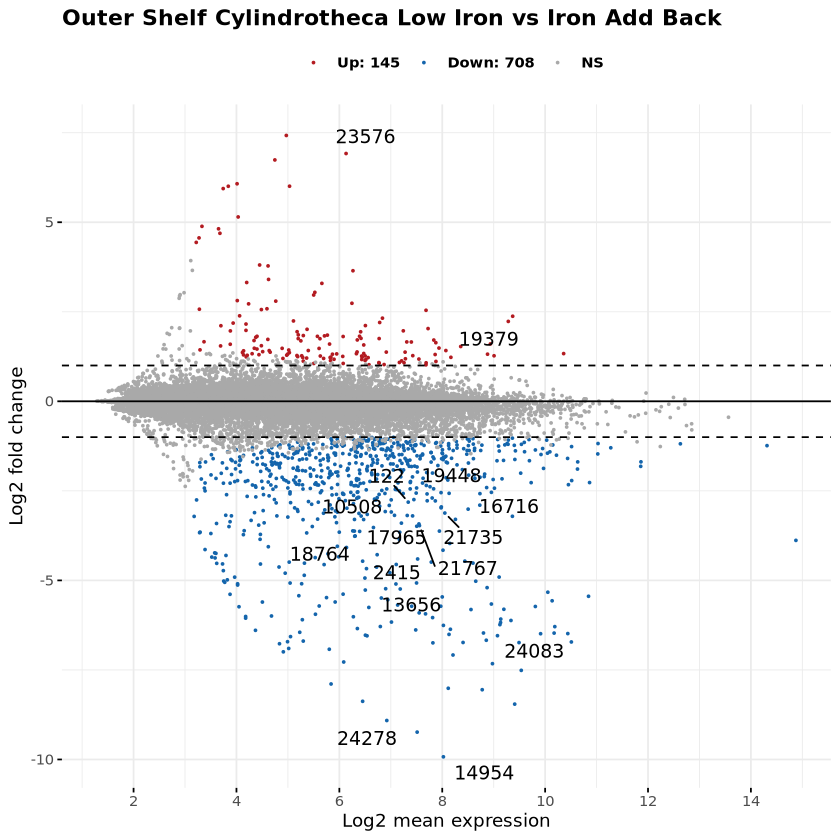

In [26]:
ma.plot(lfc4.AvL, "Outer Shelf Cylindrotheca Low Iron vs Iron Add Back")

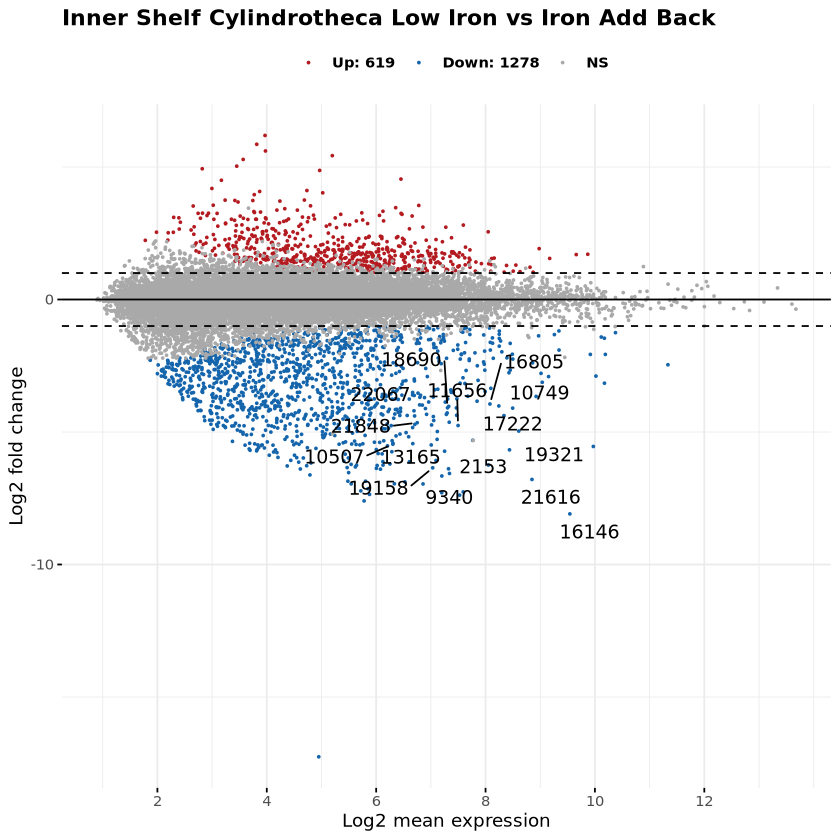

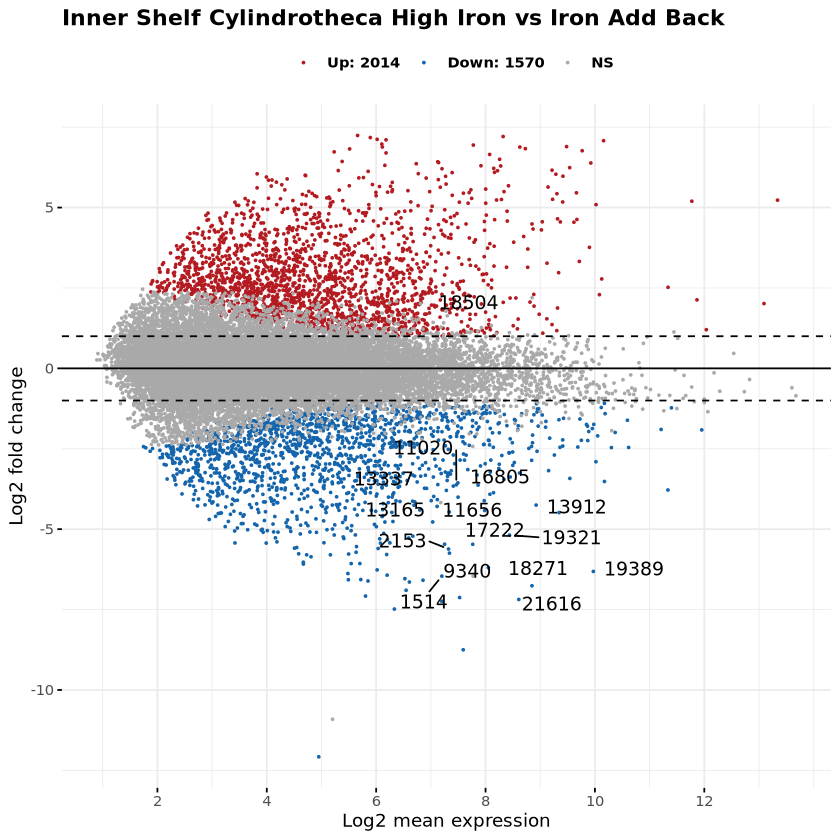

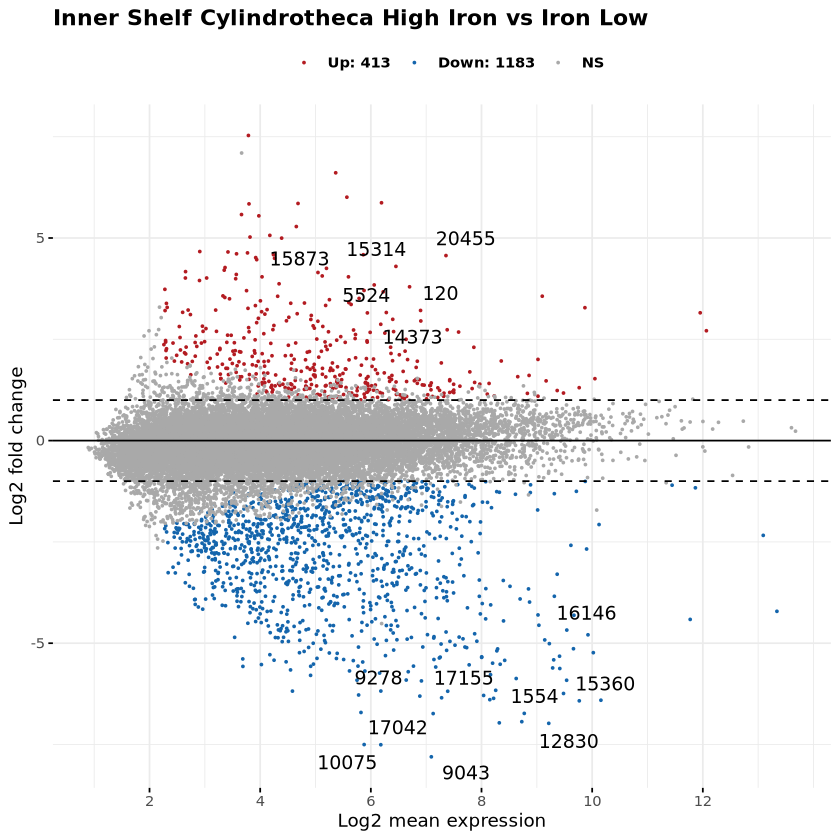

In [27]:
ma.plot(lfc8.AvL,  "Inner Shelf Cylindrotheca Low Iron vs Iron Add Back")
ma.plot(lfc8.AvH,   "Inner Shelf Cylindrotheca High Iron vs Iron Add Back")
ma.plot(lfc8.HvL,   "Inner Shelf Cylindrotheca High Iron vs Iron Low")

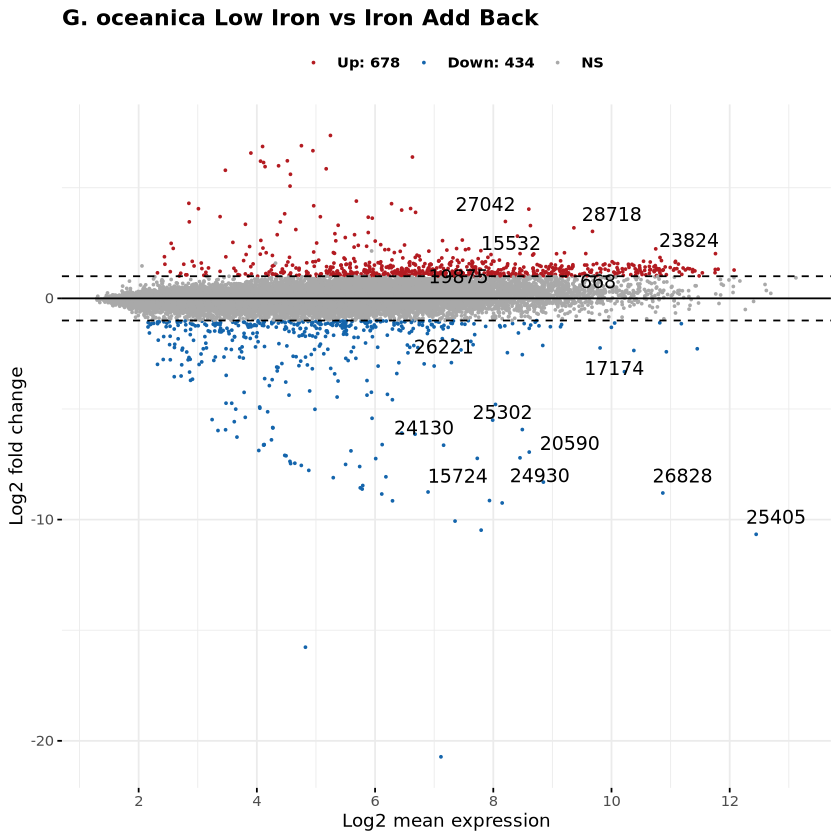

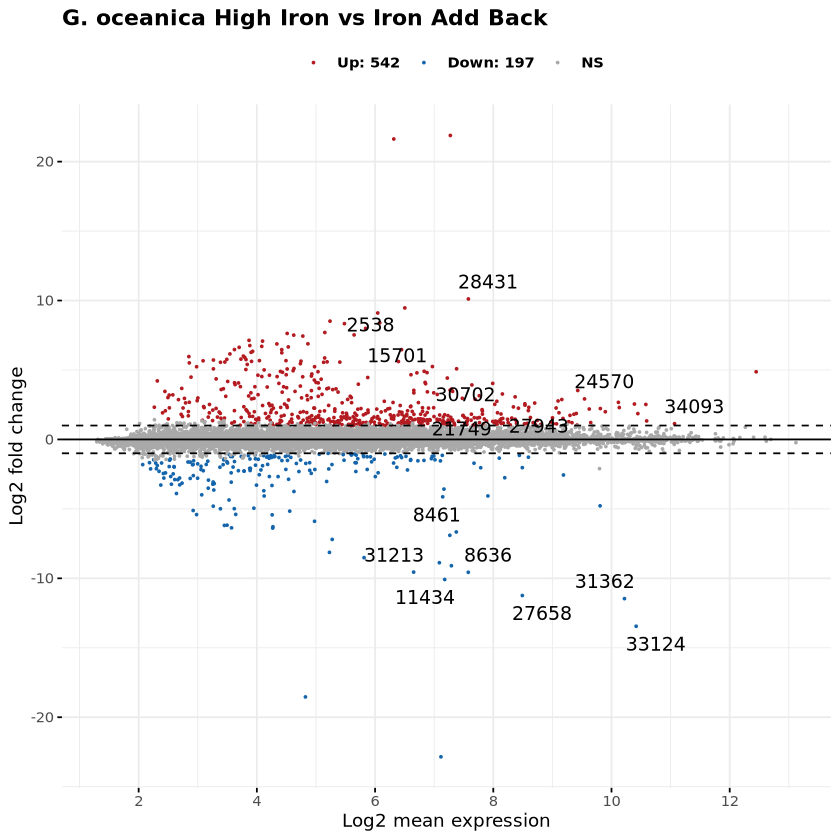

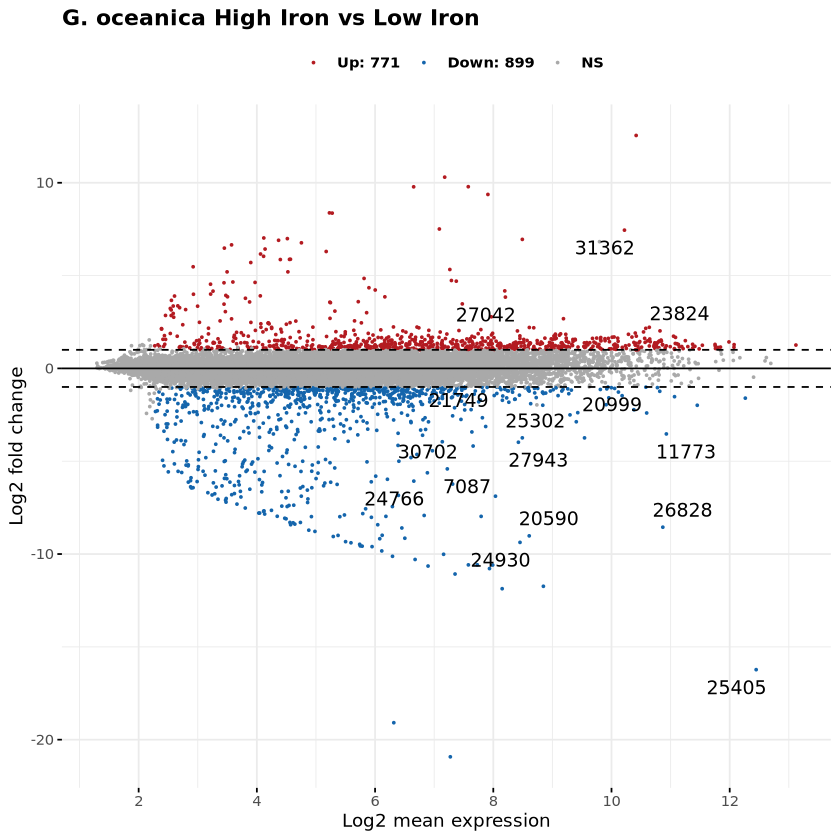

In [28]:
ma.plot(lfc6.AvL,  "G. oceanica Low Iron vs Iron Add Back")
ma.plot(lfc6.AvH,  "G. oceanica High Iron vs Iron Add Back")
ma.plot(lfc6.HvL,  "G. oceanica High Iron vs Low Iron ")

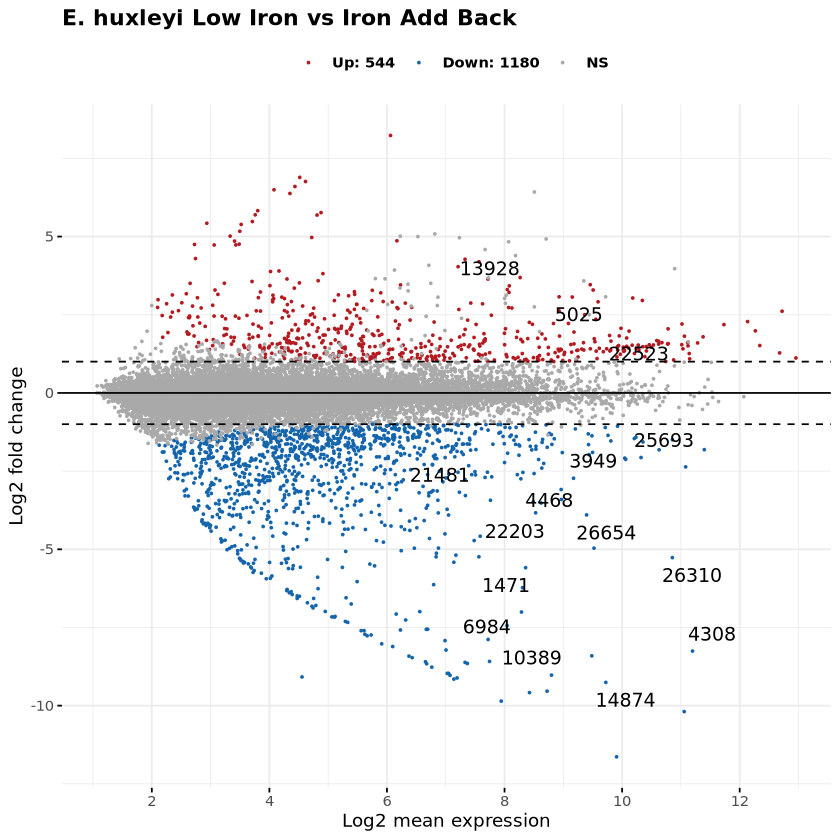

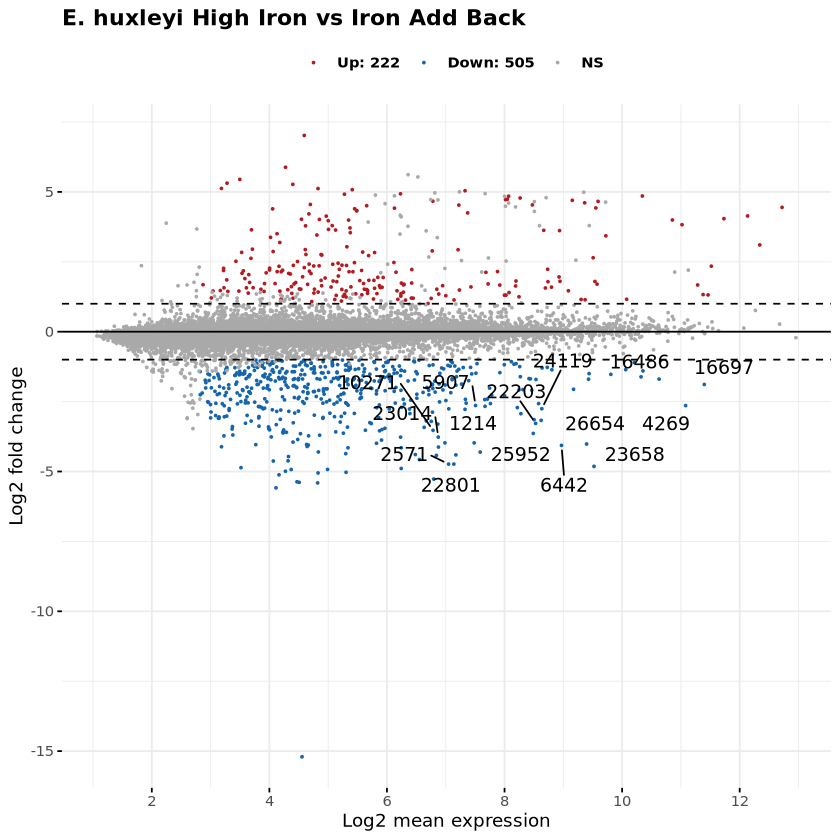

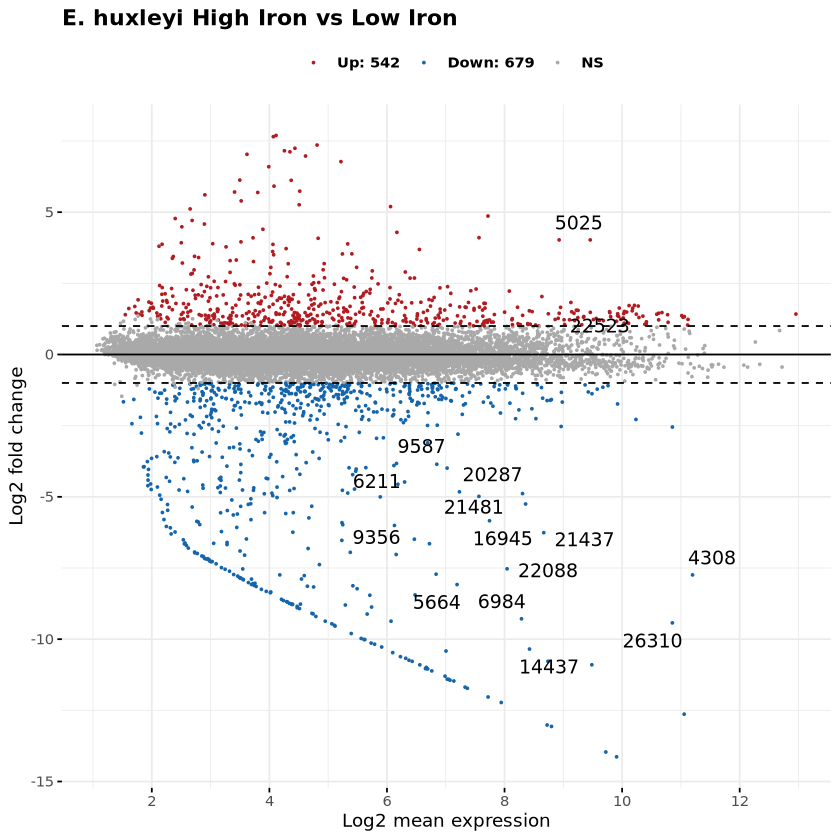

In [29]:
ma.plot(lfc13.AvL,  "E. huxleyi Low Iron vs Iron Add Back") # top= add back, bottom= low fe
ma.plot(lfc13.AvH,  "E. huxleyi High Iron vs Iron Add Back") # top= add back, bottom=low fe
ma.plot(lfc13.HvL,  "E. huxleyi High Iron vs Low Iron") #top=high fe, bottom = low fe

## Kegg-summerized counts MA
### labeling top # kegg genes (top DE) 

In [9]:
#for kegg level summarized:
ma.kegg <- function(lfc, comparison, organism, name) {
    lfc <- left_join(lfc, ko.def, by='ko_id')
    p <- ggmaplot(
        lfc, 
        main = paste(comparison),
        font.main=c(15,'bold','black'),
        submain=organism,
        font.submain= c(15,'bold.italic','black'),
        fdr = 0.05, fc = 2, 
        size = 4,
        #top=30,
        palette = c("#B31B21", "#1465AC", "darkgray"),
        genenames = as.vector(lfc$symbol),
        select.top.method='fc',
        legend = "top",
        font.label = c("bold", 10), 
        label.rectangle = T,
        font.legend = "bold", ggtheme=theme_minimal())
            
    ggsave(filename = paste(name, ".png", sep=""),p,path="/work/nclab/lucy/SAB/Annotation/figs", width = 10, height = 10)
    p

}

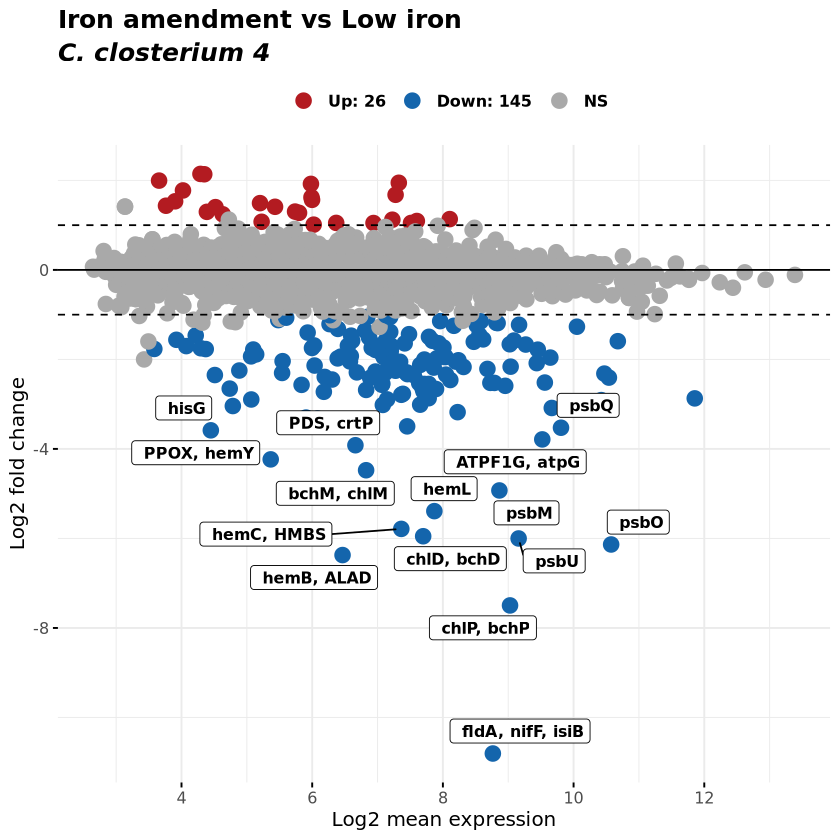

In [10]:
ma.kegg(lfc4.k.AvL, "Iron amendment vs Low iron",'C. closterium 4', "MA.4k")

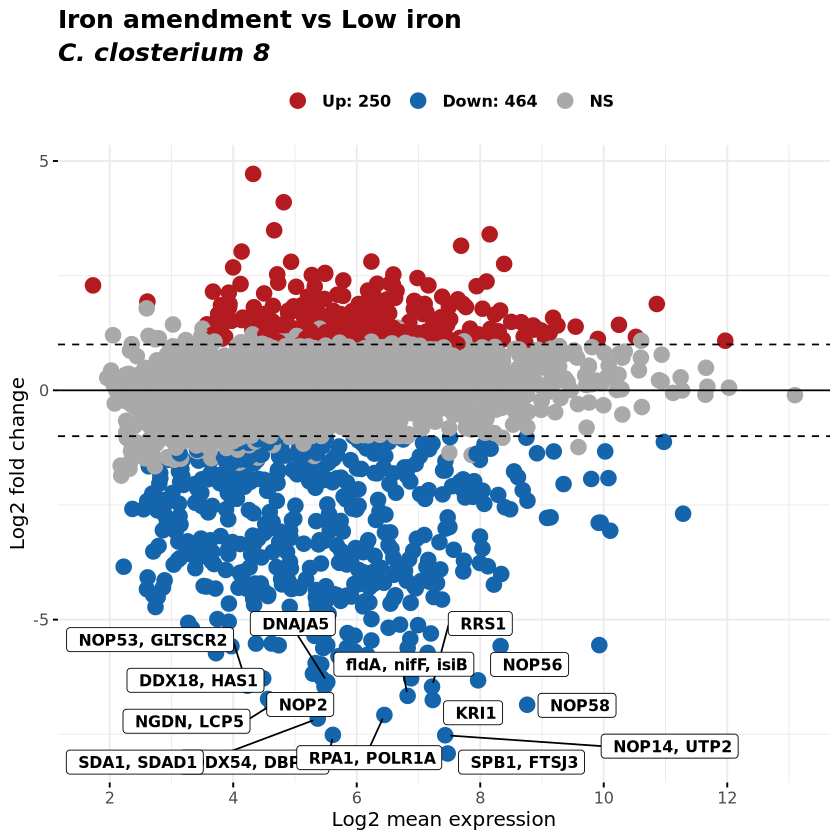

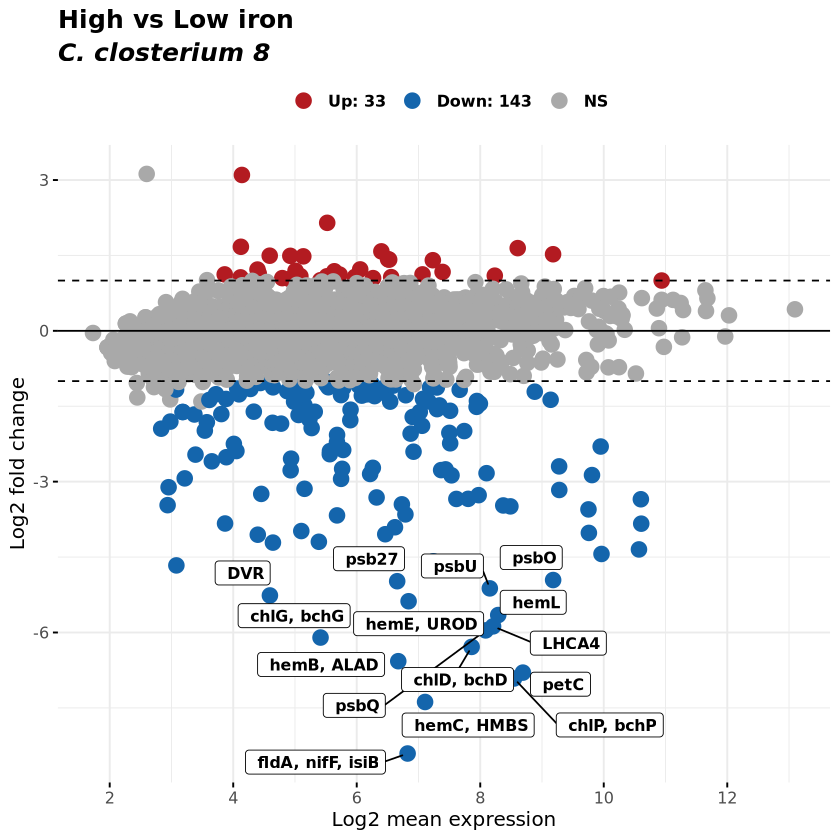

In [11]:
ma.kegg(lfc8.k.AvL,'Iron amendment vs Low iron','C. closterium 8', 'MA.8k.AL')
ma.kegg(lfc8.k.HvL,'High vs Low iron','C. closterium 8', 'MA.8k.HL')

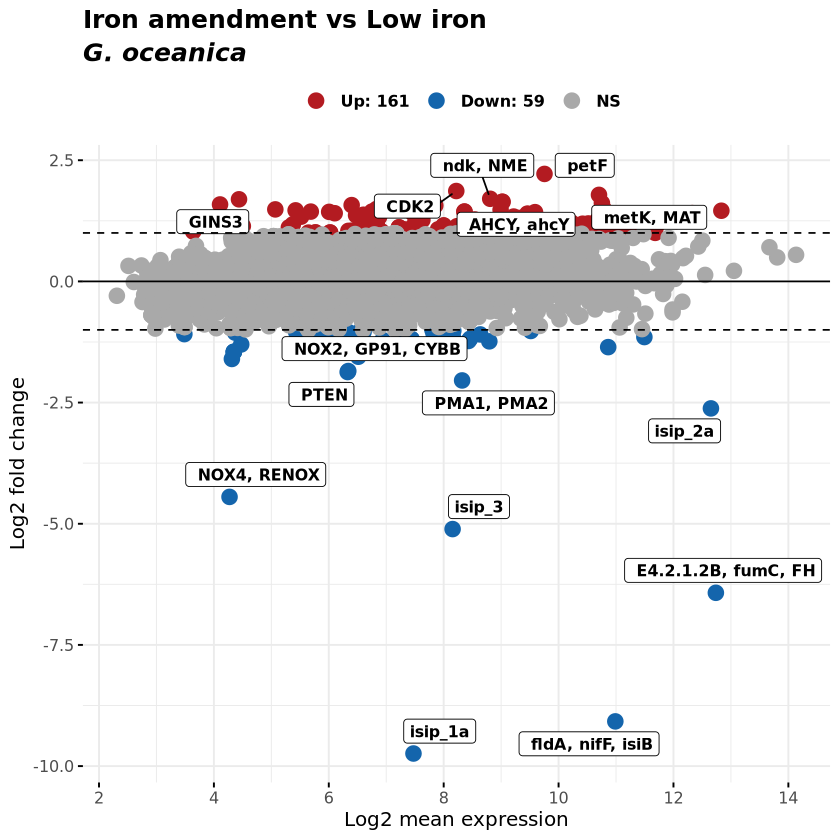

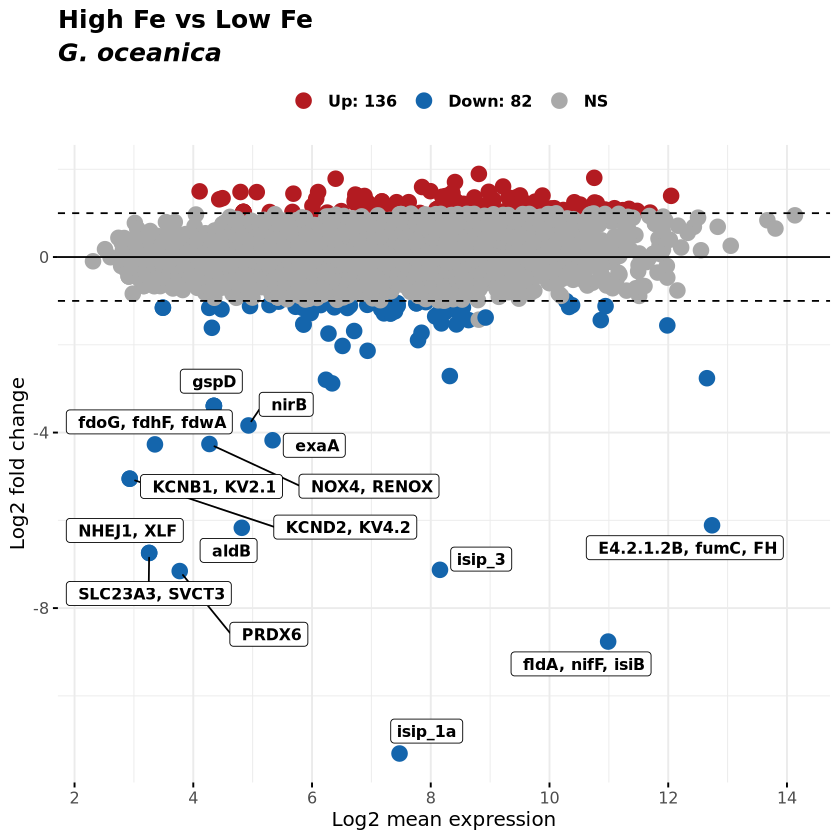

In [12]:
ma.kegg(lfc6.k.AvL, 'Iron amendment vs Low iron', 'G. oceanica','MA.6k.AL')
ma.kegg(lfc6.k.HvL, "High Fe vs Low Fe", 'G. oceanica','MA.6k.HL')

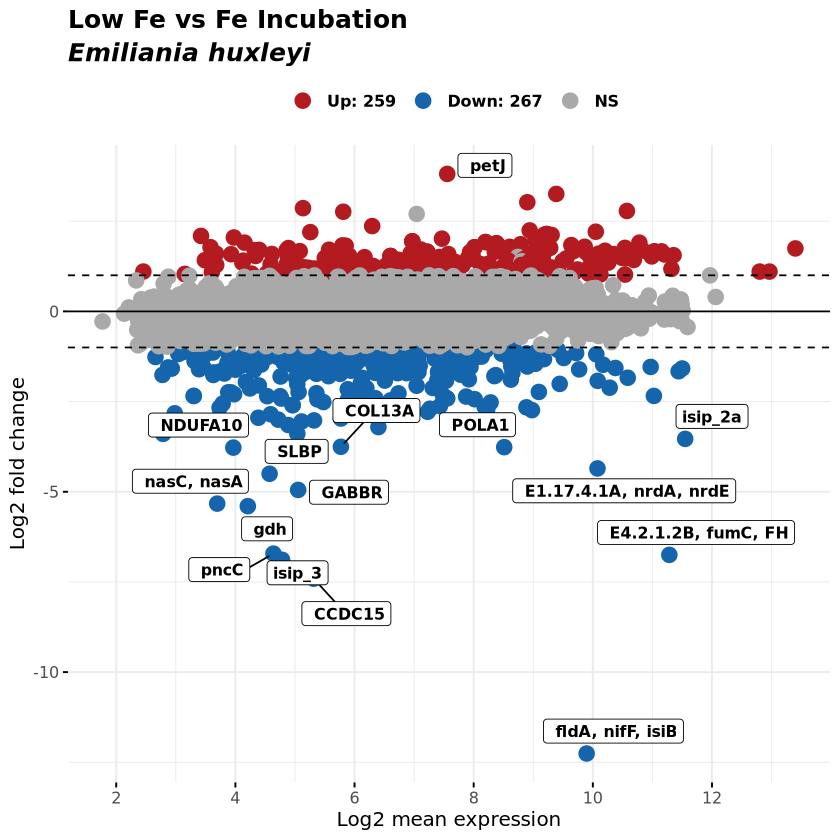

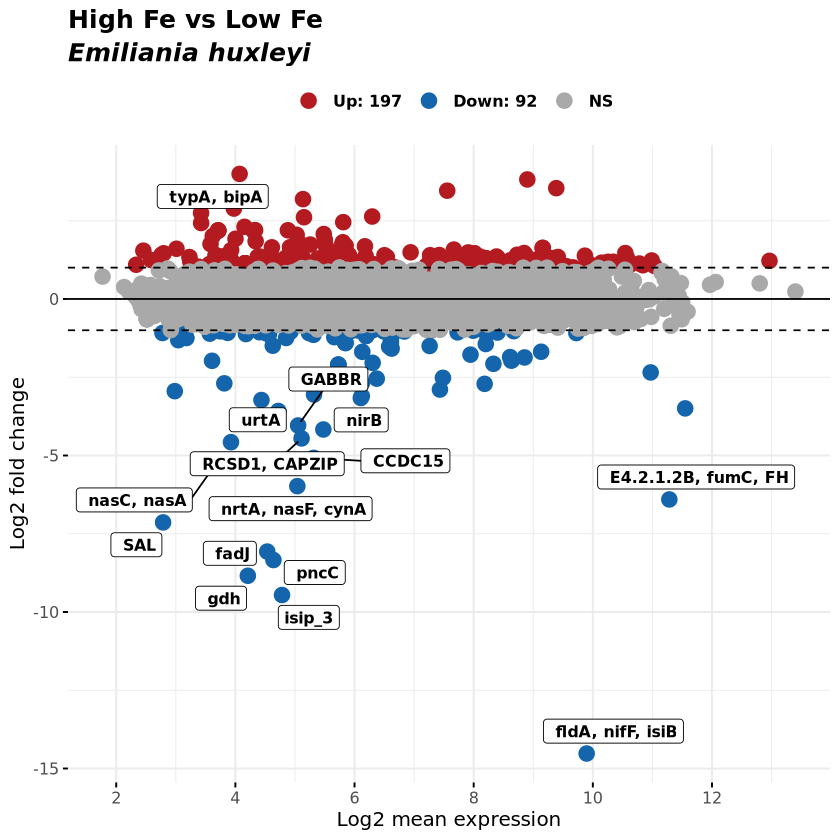

In [13]:
ma.kegg(lfc13.k.AvL, 'Low Fe vs Fe Incubation','Emiliania huxleyi', 'MA.13k.AL')
ma.kegg(lfc13.k.HvL, 'High Fe vs Low Fe', 'Emiliania huxleyi', 'MA.13k.HL')

### labeling genes of interest
I need to make a list of kegg genes I wish to point out. Maybe I can obtain this list from the heatmaps? Or I can select them based on processes I want to highlight. 
ideas for list so far:
- isip's
- nitrogen transporter
- ammonium transporter
- flavodoxin
- ferredoxin
- psi and psii

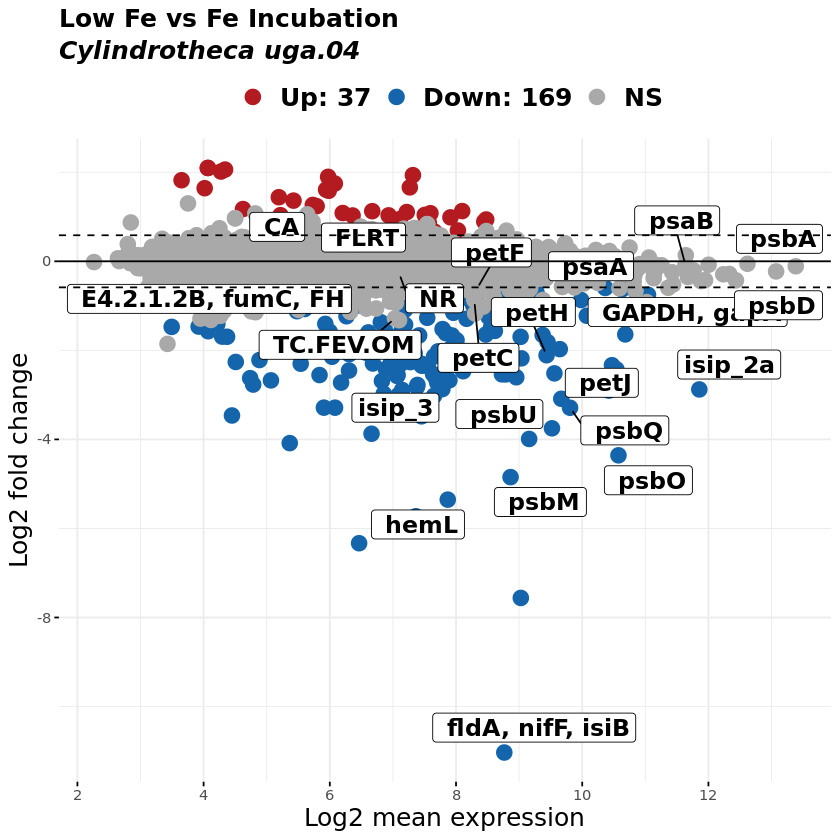

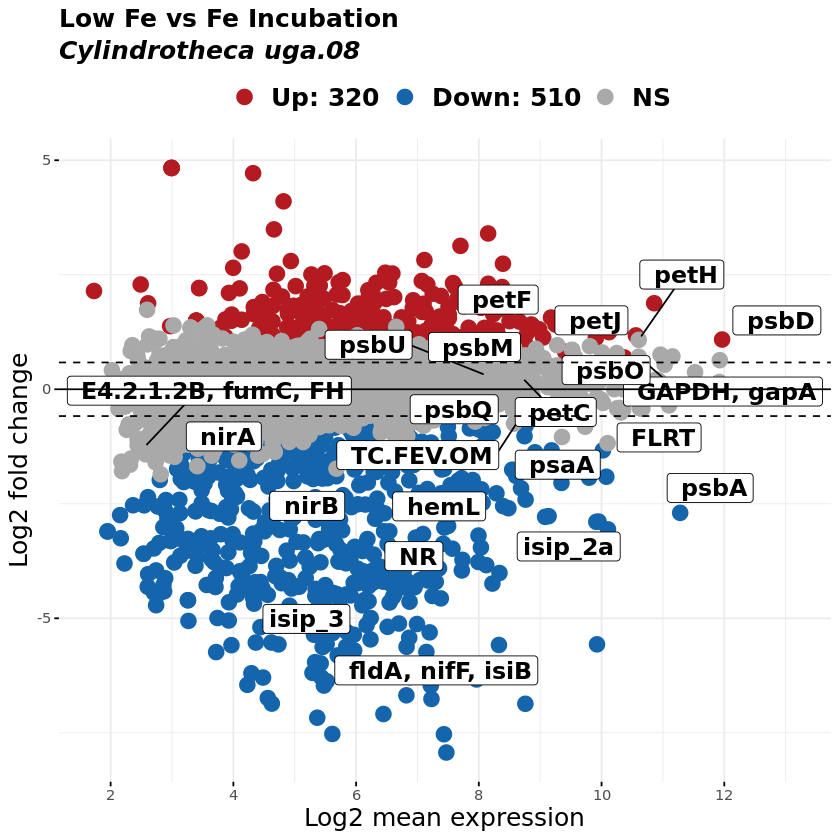

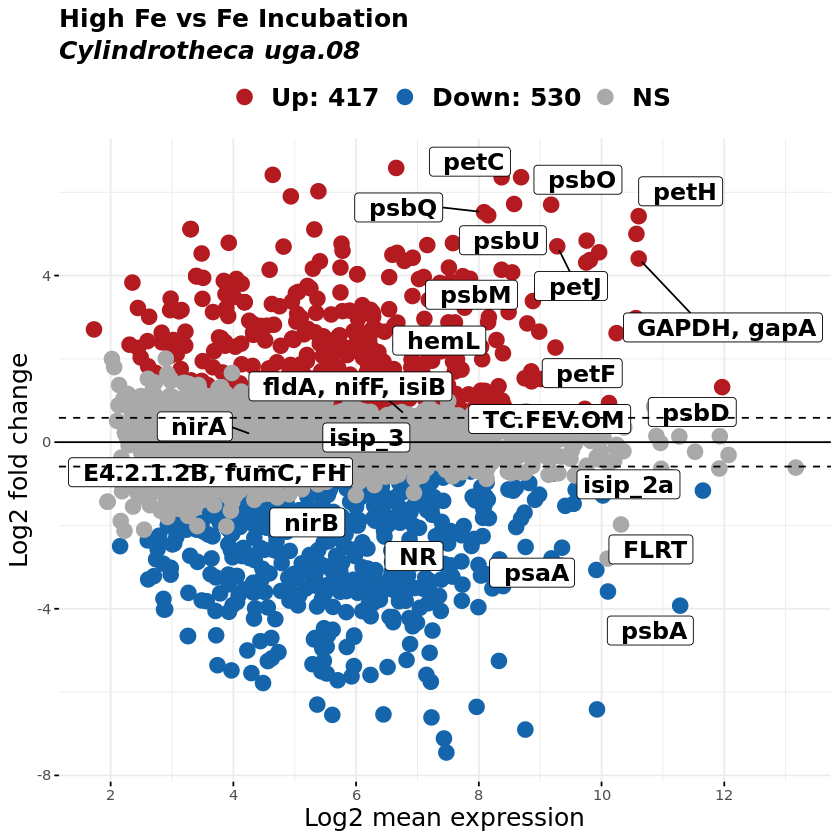

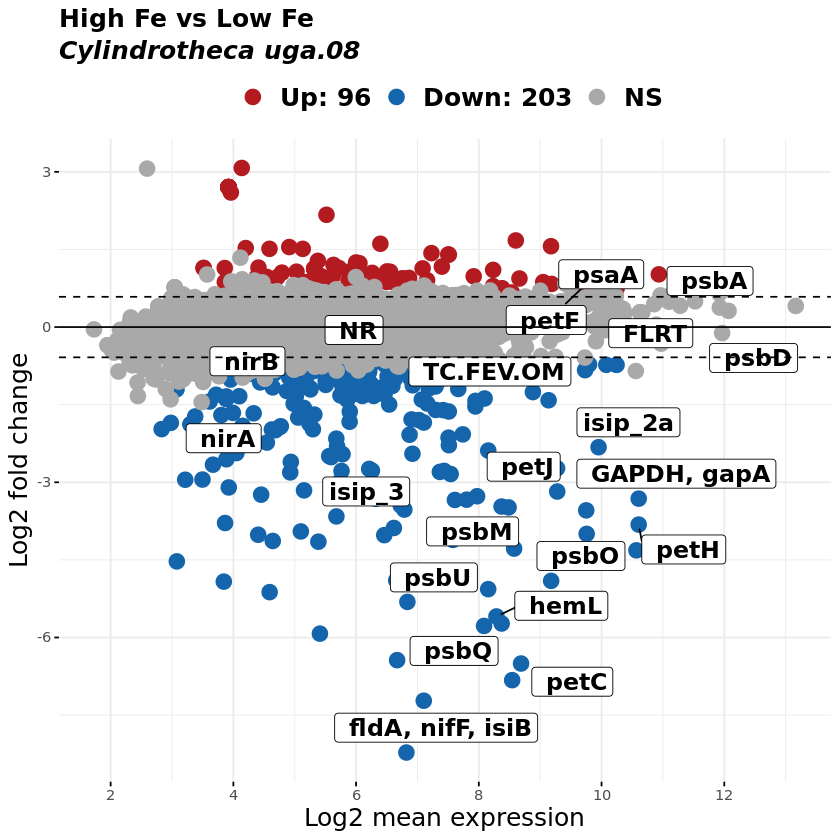

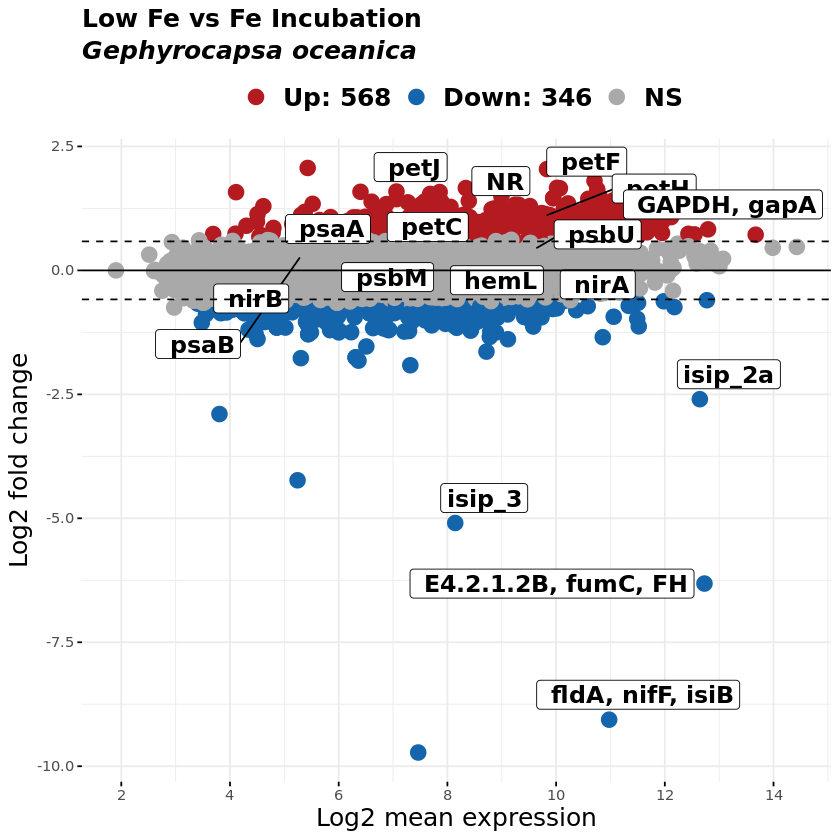

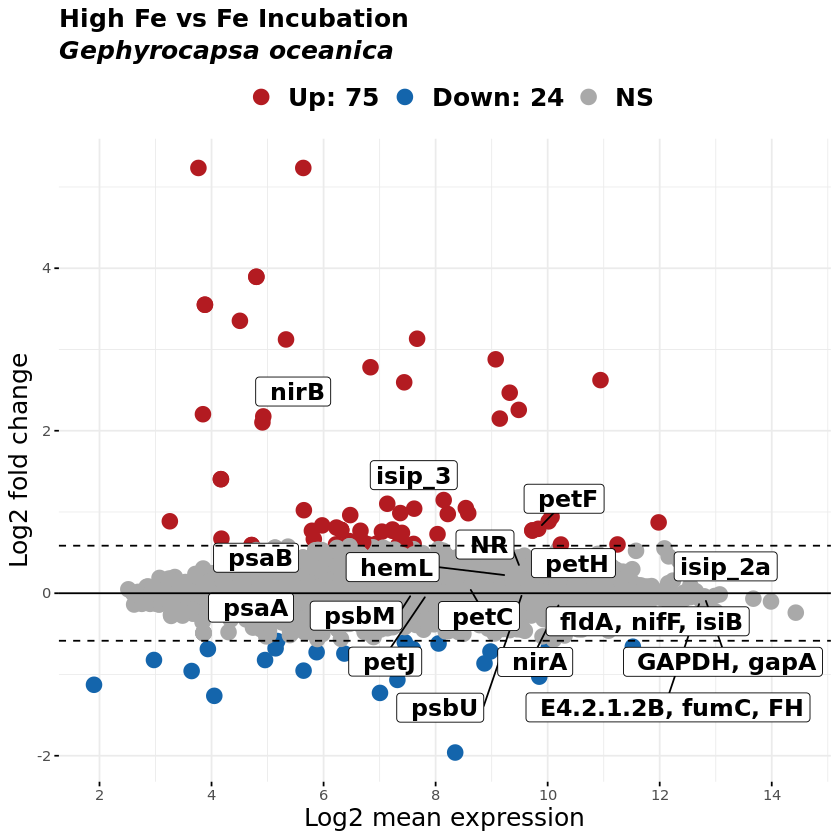

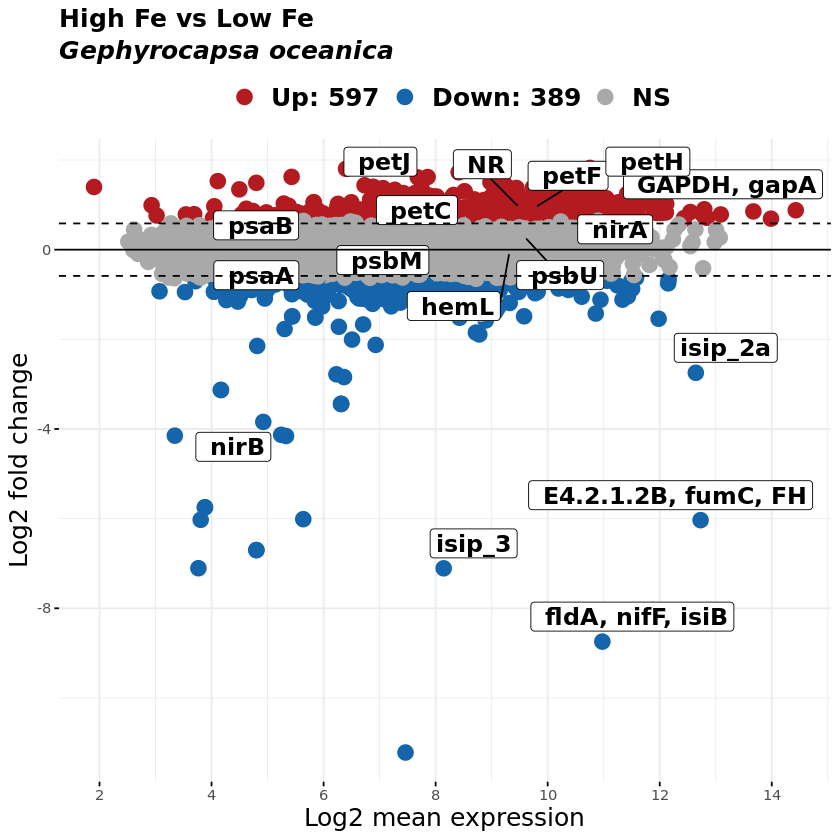

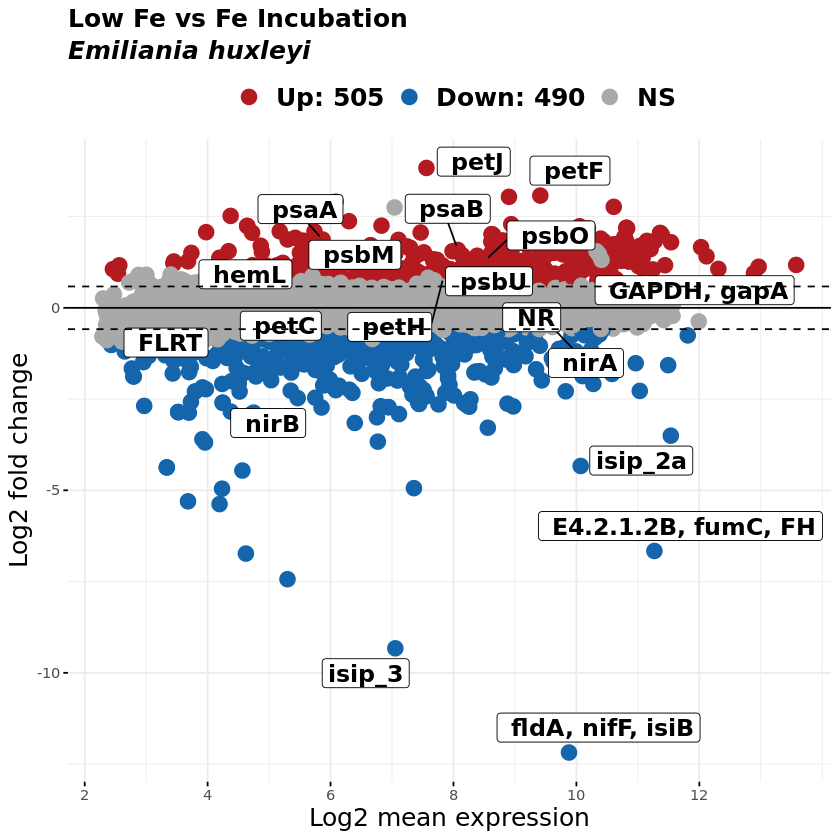

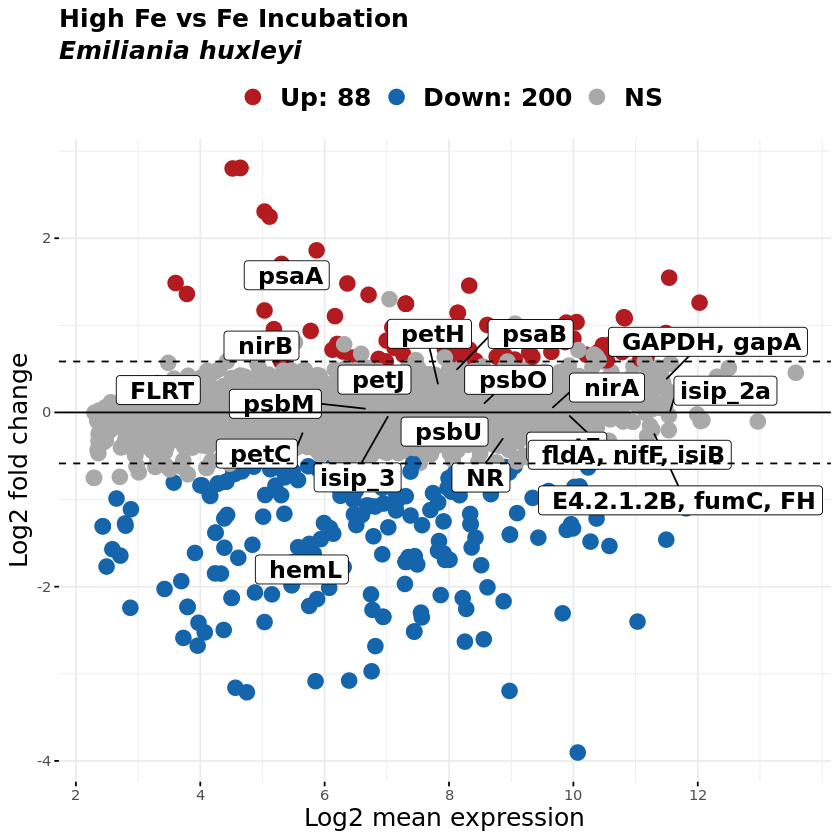

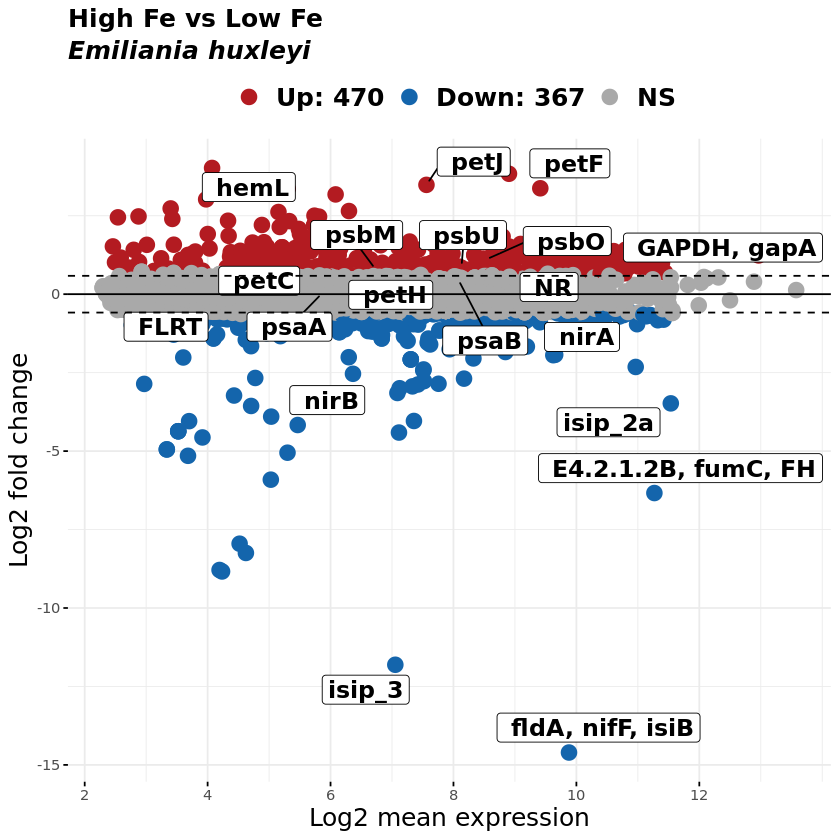

In [11]:
genes.list=c(' fldA, nifF, isiB','isip_1','isip_2','isip_2a','isip_3',' petF', ' petJ',' nirA',' nirB',' NR', ' CA',
            ' psbA',' psbU',' psbQ',' psbO',' petC',' petH',' petJ',' hemL',' TC.FEV.OM',' psbM', ' GAPDH, gapA',
             ' FLRT',' E4.2.1.2B, fumC, FH',' psbD',' psaA',' psaB')

ma.kegg.manual <- function(lfc, comparison, organism, name) {
    lfc <- left_join(lfc, ko.def, by='ko_id')
    p <- ggmaplot(
        lfc, 
        main = paste(comparison),
        font.main=c(15,'bold','black'),
        submain=organism,
        font.submain= c(15,'bold.italic','black'),
        fdr = 0.05, #fc = 1, 
        size = 4,
        top=0,
        label.select=genes.list,
        #palette = c("#B31B21", "#1465AC", "darkgray"),
        genenames = as.vector(lfc$symbol),
        select.top.method='padj',
        legend = "top",
        font.label = c(15,"bold"), 
        font.x=15,
        font.y=15,
        label.rectangle = TRUE,
        font.legend = c(15,"bold"), ggtheme=theme_minimal())
            
   ggsave(filename = paste(name, ".png", sep=""), p, 
          path="/work/nclab/lucy/SAB/Annotation/figs", width = 10, height = 10)
    p

}

ma.kegg.manual(lfc4.k.AvL, 'Low Fe vs Fe Incubation','Cylindrotheca uga.04', 'MA.4.manual.AL')

ma.kegg.manual(lfc8.k.AvL, 'Low Fe vs Fe Incubation','Cylindrotheca uga.08', 'MA.8.manual.AL')
ma.kegg.manual(lfc8.k.AvH, 'High Fe vs Fe Incubation', 'Cylindrotheca uga.08','MA.8.manual.AH') 
ma.kegg.manual(lfc8.k.HvL, 'High Fe vs Low Fe', 'Cylindrotheca uga.08', 'MA.8.manual.HL')

ma.kegg.manual(lfc6.k.AvL, 'Low Fe vs Fe Incubation','Gephyrocapsa oceanica', 'MA.6.manual.AL')
ma.kegg.manual(lfc6.k.AvH, 'High Fe vs Fe Incubation', 'Gephyrocapsa oceanica','MA.6.manual.AH') 
ma.kegg.manual(lfc6.k.HvL, 'High Fe vs Low Fe', 'Gephyrocapsa oceanica', 'MA.6.manual.HL')

ma.kegg.manual(lfc13.k.AvL, 'Low Fe vs Fe Incubation','Emiliania huxleyi', 'MA.13.manual.AL')
ma.kegg.manual(lfc13.k.AvH, 'High Fe vs Fe Incubation', 'Emiliania huxleyi','MA.13.manual.AH') 
ma.kegg.manual(lfc13.k.HvL, 'High Fe vs Low Fe', 'Emiliania huxleyi', 'MA.13.manual.HL')

In [218]:
#vsd.13=pivot_longer(vsd.13,cols=!orfs,names_to = 'treatment', values_to='counts')
vsd.13$treatment=str_remove(vsd.13$treatment, '[ABC]')

vsd.13$iron[vsd.13$treatment=='pFe19']='High Fe'
vsd.13$iron[vsd.13$treatment=='pFe21_9']='Low Fe'
vsd.13$iron[vsd.13$treatment=='add_back']='Add Back'
head(vsd.13)

Warning message:
“Unknown or uninitialised column: `iron`.”


orfs                                              treatment counts   iron    
1 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 add_back  2.969569 Add Back
2 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 add_back  2.969569 Add Back
3 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 add_back  4.449069 Add Back
4 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 pFe19     2.969569 High Fe 
5 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 pFe19     3.478959 High Fe 
6 NODE_4354_length_2814_cov_1492.290405_g1501_i1.p1 pFe19     2.969569 High Fe

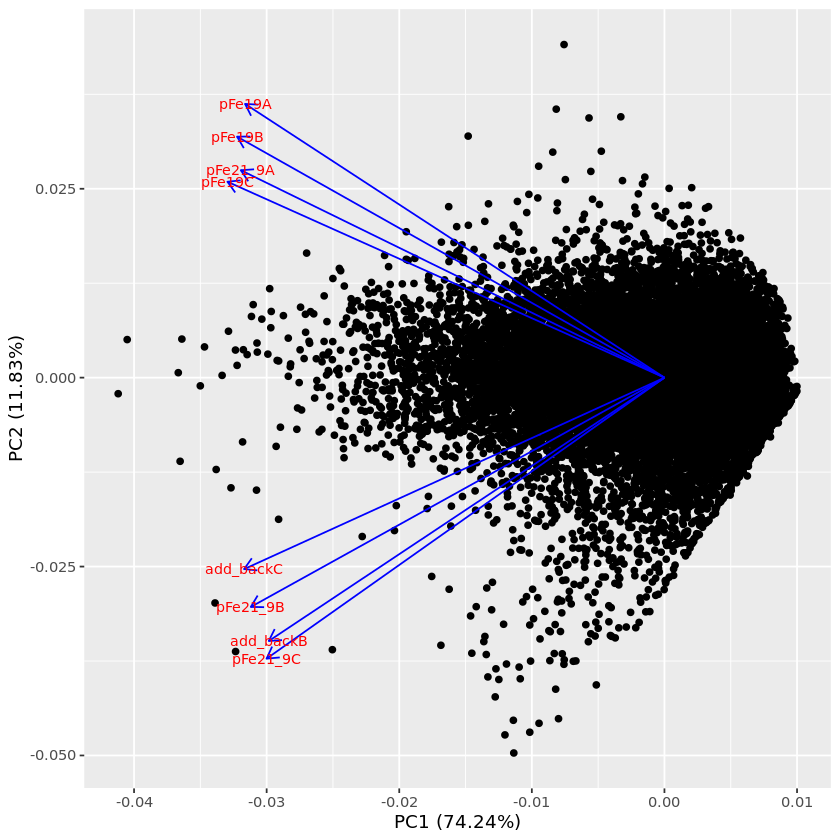

In [225]:
library(ggfortify)
df=vsd.8[-1]
pca_res <- prcomp(df, scale. = TRUE)
autoplot(pca_res, data = vsd.8, 
         loadings = TRUE, loadings.colour = 'blue',
         loadings.label = TRUE, loadings.label.size = 3)

# Heatmaps 

## all orfs

In [4]:
#get list of shared orfs
all_df = bind_rows(vsd.8.kegg[,1:3], vsd.4.kegg[,1:3], vsd.6.kegg[,1:3], vsd.13.kegg[,1:3]) 
all_df = all_df[duplicated(all_df$ko_id),] %>% select(ko_id)
 head(all_df)


ko_id 
2823 K02716
2824 K08901
2825 K03839
2826 K10960
2827 K08910
2828 K02636

In [34]:
heat.all.orf=function(vsd, org, name){
    vsd = filter(vsd, ko_id %in% all_df$ko_id==T)
    mat_var <- column_to_rownames(vsd,'ko_id' )%>% as.matrix #turn into matrix
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #z-score

    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno$Organism <- str_extract(col.anno$id, '\\d{1,2}')
    col.anno$Treatment <- str_extract(col.anno$id, '((pFe\\d{1,2}|add)_(9|back)|pFe19)')
    col.anno$Treatment = str_replace_all(col.anno$Treatment, c('pFe19'='High Iron','pFe21_9'='Low Iron','add_back'='Iron\nAmendment'))
    col.anno$Treatment = factor(col.anno$Treatment, levels = c('High Iron','Low Iron','Iron\nAmendment'))
    col.anno$rep <- str_extract(col.anno$id, '[ABC]')
                                
    col.anno <- HeatmapAnnotation(
        Treatment=col.anno$Treatment, 
        col = list(Treatment=c('High Iron' = "black", 'Low Iron' = "white", 'Iron\nAmendment' = "grey"))) 
    
    png(file = paste('../figs/heat.k.all.', org, '.png', sep=''),width = 600,height = 800)
    ht = Heatmap(mat_var, cluster_columns = T, cluster_rows=T, show_row_dend = F,
                 column_title = paste(name), show_column_names = FALSE,col=inferno(100),
                 show_row_names = F, top_annotation = col.anno, heatmap_legend_param=list(
                     title="Z-scored \nVST \nnormalized \ncounts", position='topcenter'))
    
    draw(ht)
    dev.off()
    ht
}


In [35]:
all.4 = heat.all.orf(vsd.4.kegg, '04', 'C. closterium\nUGA4')
all.8 = heat.all.orf(vsd.8.kegg, '08', 'C. closterium\nUGA8')
all.6 = heat.all.orf(vsd.6.kegg, '06', 'G. oceanica')
all.13 = heat.all.orf(vsd.13.kegg, '13', 'G. huxleyi')

In [37]:
all_orf_heatmap = ggarrange(grid.grabExpr(draw(all.8)), grid.grabExpr(draw(all.4)), grid.grabExpr(draw(all.6)), grid.grabExpr(draw(all.13)), 
          nrow=2,ncol=2,  labels='AUTO')


In [38]:
ggsave('../figs/all_orf_heatmaps.png', all_orf_heatmap, device='png',height=10, width=9)

## Kegg-summed orfs 

In [13]:
heat.map <- function(vsd, org, name){
   # vsd <- vsd[0:50,] #subset top 50 genes
    mat_var <- column_to_rownames(vsd,'ko_id' )%>% as.matrix #turn into matrix
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #z-score

    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno$Organism <- str_extract(col.anno$id, '\\d{1,2}')
    col.anno$Treatment <- str_extract(col.anno$id, '((pFe\\d{1,2}|add)_(9|back)|pFe19)')
    col.anno$rep <- str_extract(col.anno$id, '[ABC]')
    col.anno <- HeatmapAnnotation(Treatment=col.anno$Treatment, col = list(Treatment=c(
            'pFe19' = "black", 
            'pFe21_9' = "white", 
            'add_back' = "grey"))) 
    
    row_names <- left_join(vsd, ko.def, by='ko_id') %>%
                        select('ko_id', 'symbol', 'name')
   new_names <- structure(row_names$symbol,  names=row_names$ko_id) #rename rows with kegg symbols

    
   png(file = paste('../figs/heat.top.', org, '.png', sep=''),width = 800,height = 800)
    
   ht=Heatmap(mat_var,cluster_columns = FALSE,column_title = name,
              col=inferno(100),
           show_column_names = FALSE,
            row_labels = new_names[rownames(mat_var)],
            top_annotation = col.anno, #right_annotation=row.anno,
            row_names_gp = gpar(fontsize = 10),
            clustering_method_rows = "complete",
            heatmap_legend_param=list(title="Z-scored \nVSD \nnormalized \ncounts",
                                        position='topcenter'))
    
    draw(ht[1:50])
    ht[1:50]
    
}

x=heat.map(vsd.4.kegg, '04', 'C. closterium 4')
draw(x)


In [63]:
heat.map(vsd.8.kegg, '08', 'C. closterium 8')

In [64]:
heat.map(vsd.6.kegg, '06', 'G. oceanica')

In [66]:

heat.map(vsd.13.kegg, '13', 'G. huxleyi')

## Protein-specific heatmaps
<b/>Using module and pathway df's created in kegg script.</b>
### 1. Create a table with significance from DE.


In [10]:

get.sig=function(HIGH,ADD){
    hvl.sig=filter(HIGH, padj<0.05)
    hvl.sig=data.frame('ko_id'=hvl.sig$ko_id, 'HvL'='*')
    avl.sig=filter(ADD, padj<0.05)
    avl.sig=data.frame('ko_id'=avl.sig$ko_id, 'AvL'='*')
    sig.ko=full_join(hvl.sig, avl.sig)
    ko.missing=ko.def[(ko.def$ko_id%in%sig.ko$ko_id==F), ]
    ko.missing=data.frame(ko_id=ko.missing$ko_id, 'HvL'=' ','AvL'=' ')
    sig.final=bind_rows(sig.ko, ko.missing)
    #sig.final=filter(sig.final,(ko_id %in% ko.def$ko_id))
    sig.final[is.na(sig.final)]=' '
    sig.final
    }
sig.ko13=get.sig(lfc13.k.HvL,lfc13.k.AvL)
sig.ko8=get.sig(lfc8.k.HvL, lfc8.k.AvL)
sig.ko6=get.sig(lfc6.k.HvL, lfc6.k.AvL)
sig.ko4={
    avl.sig=filter(lfc4.k.AvL, padj<0.05)
    sig.ko=data.frame('ko_id'=avl.sig$ko_id,'HvL'=' ', 'AvL'='*')
    ko.missing=ko.def[(ko.def$ko_id%in%sig.ko$ko_id==F), ]
    ko.missing=data.frame(ko_id=ko.missing$ko_id, 'HvL'=' ','AvL'=' ')
    sig.final=bind_rows(sig.ko, ko.missing)
    #sig.final=filter(sig.final,(ko_id %in% ko.def$ko_id))
    sig.final[is.na(sig.final)]=' '
    sig.final}


Joining with `by = join_by(ko_id)`
Joining with `by = join_by(ko_id)`
Joining with `by = join_by(ko_id)`


### 2. Make preliminary annotations

In [11]:
####      call these functions in figure making functions to make the row and column annotations ####

col.anno = function(vsd, org){
    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno <- data.frame('id'=col.anno$id,
                           'Treatment'=str_extract(col.anno$id,'((pFe\\d{1,2}|add)_(9|back)|pFe19)'))
    if (org=='Gephyrocapsa \nhuxleyi'){
        col.org <- "#3456CA"
        isolate='13'
    }else if (org=='Gephyrocapsa \noceanica'){
        col.org <- "#90A1DA"
        isolate='06'
    }else if (org=='Cylindrotheca \nclosterium UGA4'){
        col.org <- "#0F6104"
        isolate='04'
    }else{
        col.org <- "#9AB18D"
        isolate='08'}
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
    
    col.anno <- HeatmapAnnotation(
        'Isolate'=anno_block(
            gp=gpar(fill=col.org, col=col.org),
            labels=org,
            labels_gp=gpar(fontface='bold.italic', col='black', fontsize=25)),
        'Treatment'=anno_simple(col.anno$Treatment, 
            col = c(
                 'pFe19' = "black",
                 'pFe21_9' = "white",
                  'add_back' = "grey")),
        annotation_name_gp=gpar(fontsize=25),
        show_annotation_name=legend.show) }



### 3. Set up Pathway data 
#### I. Read in Module and Pathway information.
This will subset genes (KO's) by the pathway or module associated with them.


#### II. Filter list for genes expressed by isolates
Not all ko's in each path will be expressed, filter out those so that pathway lists contain ko's expressed by at least one organism

In [12]:
all.path = read.csv('../kegg_names/pathwaysHeatMap.csv')
a=unique(vsd.4.kegg$ko_id)
a=a[a%in%all.path$ko_id]

b=unique(vsd.8.kegg$ko_id)
b=b[b%in%all.path$ko_id]

c=unique(vsd.6.kegg$ko_id)
c=c[c%in%all.path$ko_id]

d=unique(vsd.13.kegg$ko_id)
d=d[d%in%all.path$ko_id]


length(b)
length(c)
length(d)
length(a)
x=union(a,b)
y=union(c,d)
z=union(x,y)

length(x)
length(y)
length(z)
all.path=all.path[(all.path$ko_id)%in%z,]

dim(all.path)
filter(ko.def, ko_id=='K08717')
filter(ko.def, ko_id=='K08716')


[1] 75

[1] 85

[1] 82

[1] 67

[1] 79

[1] 88

[1] 100

[1] 100   7

ko_id  symbol name             
1 K08717  utp    urea transporter

ko_id  symbol  name                                        
1 K08716  SLC14A  solute carrier family 14 (urea transporter)

#### III. Adjust subcategory names and gene names for plotting later

In [13]:
addGenes=filter(ko.def, ko_id %in%c('K03320','K01427','K04564','K04565','K08717','K08716'))
addGenes$name=str_remove(addGenes$name, '\\[.*\\]')
addGenes= mutate(addGenes, Path='map1111', 
                 sub_category=c('Nitrogen transporters', 'Nitrogen transporters','Superoxide dismutase','Nitrogen transporters','Superoxide dismutase','Urea cycle'),
                 broad_category=c('Nitrogen metabolism','Nitrogen metabolism','Photosynthesis','Nitrogen metabolism','Photosynthesis','Nitrogen metabolism'),
                 path_name=c('Nitrogen metabolism','Nitrogen metabolism','Photosynthesis','Nitrogen metabolism','Photosynthesis','Nitrogen metabolism'))
isip=ko.def[str_detect(ko.def$symbol,'isip.*')==T,]
isip=mutate(isip,Path='map1111', sub_category='ISIP', broad_category='Photosynthesis', path_name='Photosynthesis')
all.path=bind_rows(all.path, addGenes, isip)

all.path$name.2=str_squish(all.path$name)
tail(all.path,10)

Path     ko_id   symbol              
100 map00910 K01476   E3.5.3.1, rocF, arg
101 map1111  K03320   amt, AMT, MEP      
102 map1111  K08717   utp                
103 map1111  K04564   SOD2               
104 map1111  K08716   SLC14A             
105 map1111  K04565   SOD1               
106 map1111  K01427   URE                
107 map1111  isip_1a isip_1a             
108 map1111  isip_2a isip_2a             
109 map1111  isip_3  isip_3              
    name                                         sub_category         
100  arginase                                    Urea cycle           
101  ammonium transporter, Amt family            Nitrogen transporters
102  urea transporter                            Nitrogen transporters
103  superoxide dismutase, Fe-Mn family          Superoxide dismutase 
104  solute carrier family 14 (urea transporter) Nitrogen transporters
105  superoxide dismutase, Cu-Zn family          Superoxide dismutase 
106  urease                                      Urea cycle           
107 Iron stress induced protein 1a               ISIP                 
108 Iron stress induced protein 2a               ISIP                 
109 Iron stress induced protein 3                ISIP                 
    broad_category      path_name          
100 Nitrogen metabolism Nitrogen metabolism
101 Nitrogen metabolism Nitrogen metabolism
102 Nitrogen metabolism Nitrogen metabolism
103 Photosynthesis      Photosynthesis     
104 Nitrogen metabolism Nitrogen metabolism
105 Photosynthesis      Photosynthesis     
106 Nitrogen metabolism Nitrogen metabolism
107 Photosynthesis      Photosynthesis     
108 Photosynthesis      Photosynthesis     
109 Photosynthesis      Photosynthesis     
    name.2                                     
100 arginase                                   
101 ammonium transporter, Amt family           
102 urea transporter                           
103 superoxide dismutase, Fe-Mn family         
104 solute carrier family 14 (urea transporter)
105 superoxide dismutase, Cu-Zn family         
106 urease                                     
107 Iron stress induced protein 1a             
108 Iron stress induced protein 2a             
109 Iron stress induced protein 3

In [14]:
#filter(all.path, sub_category=='Urea cycle')
all.path[all.path$symbol==' ureG','name.2']='urease G'
all.path[all.path$symbol==' ureF','name.2']='urease F'
all.path[all.path$symbol=='CPS1','name.2']='carbamoyl-phosphate synthase 1'
all.path[all.path$symbol=='SLC14A','name.2']='SCF 14 urea transporter'
#filter(all.path, sub_category=='Superoxide dismutase')
all.path$name.2 = str_replace(all.path$name.2,'.*superoxide dismutase,','SOD')

#filter(all.path, sub_category=='Electron transport chain')
all.path[all.path$symbol=='petC','name.2'] = 'cytochrome b6f iron-sulfur subunit'

#filter(all.path, sub_category=='PSI')
all.path$name.2 = str_replace(all.path$name.2, 'psa', 'PSI')

filter(all.path, sub_category=='PSII')
all.path$name.2 = str_replace(all.path$name.2, 'psb', 'PSII')
all.path$name.2 = str_remove(all.path$name.2, 'reaction center')
all.path$name.2 = str_replace(all.path$name.2, 'oxygen-evolving enhancer', 'OEC')
all.path$name.2 = str_replace(all.path$name.2, '13kDa', 'Psb28')
#filter(all.path, sub_category%in%c('LHCA','LHCB'))
all.path$name.2 = str_remove(all.path$name.2, 'Chl a/b binding protein ')
all.path[str_detect(all.path$sub_category, 'LHCA'), 'sub_category']='PSI'
all.path[str_detect(all.path$sub_category, 'LHCB'), 'sub_category']='PSII'
#filter(all.path, sub_category=='Xanthophyll cycle')

#filter(all.path, sub_category=='Nitrite reductase')
all.path$sub_category = str_replace(all.path$sub_category, 'Nitrite', 'Nitrate/Nitrite')

filter(all.path, sub_category=='Nitrate/Nitrite reductase')
all.path$name.2 = str_remove(all.path$name.2, 'catalytic subunit')

#filter(all.path, sub_category=='Nitrogen transporters')
all.path$name.2 = str_remove(all.path$name.2, '.system')
all.path$name.2= str_replace(all.path$name.2, 'nitrate/nitrite transport substrate-binding protein', 'nitrate/nitrite transport substrate-binding\nprotein')
filter(all.path, sub_category=='Nitrogen transporters')

filter(all.path, sub_category=='GS/GOGAT')
all.path[str_detect(all.path$name.2,'glutamate dehydrogenase'),'sub_category'] = 'GDH'
all.path$sub_category = str_remove(all.path$sub_category, ' and GDH')
all.path[str_detect(all.path$symbol,'ncd2|CYP55'),'sub_category'] = 'Nitrogen recycling'
filter(all.path, sub_category=='GDH')
all.path$name.2 = str_replace(all.path$name.2, 'dehydrogenase \\(oxaloacetate', 'dehydrogenase\n\\(oxaloacetate')

Path     ko_id  symbol name                                   sub_category
1  map00195 K02703 psbA   psb P680 reaction center D1 protein    PSII        
2  map00195 K02704 psbB   psb CP47 Chl apoprotein                PSII        
3  map00195 K02705 psbC   psb CP43 Chl apoprotein                PSII        
4  map00195 K02706 psbD   psb P680 reaction center D2 protein    PSII        
5  map00195 K02714 psbM   psb PsbM protein                       PSII        
6  map00195 K02716 psbO   psb oxygen-evolving enhancer protein 1 PSII        
7  map00195 K02717 psbP   psb oxygen-evolving enhancer protein 2 PSII        
8  map00195 K02719 psbU   psb PsbU protein                       PSII        
9  map00195 K08901 psbQ   psb oxygen-evolving enhancer protein 3 PSII        
10 map00195 K08902 psb27  psb Psb27 protein                      PSII        
11 map00195 K08903 psb28  psb 13kDa protein                      PSII        
   broad_category path_name      name.2                                
1  Photosynthesis Photosynthesis psb P680 reaction center D1 protein   
2  Photosynthesis Photosynthesis psb CP47 Chl apoprotein               
3  Photosynthesis Photosynthesis psb CP43 Chl apoprotein               
4  Photosynthesis Photosynthesis psb P680 reaction center D2 protein   
5  Photosynthesis Photosynthesis psb PsbM protein                      
6  Photosynthesis Photosynthesis psb oxygen-evolving enhancer protein 1
7  Photosynthesis Photosynthesis psb oxygen-evolving enhancer protein 2
8  Photosynthesis Photosynthesis psb PsbU protein                      
9  Photosynthesis Photosynthesis psb oxygen-evolving enhancer protein 3
10 Photosynthesis Photosynthesis psb Psb27 protein                     
11 Photosynthesis Photosynthesis psb 13kDa protein

Path     ko_id  symbol     name                                             
1 map00910 K00362 nirB       nitrite reductase (NADH) large subunit           
2 map00910 K00366 nirA       ferredoxin-nitrite reductase                     
3 map00910 K00372 nasC, nasA assimilatory nitrate reductase catalytic subunit 
4 map00910 K10534 NR         nitrate reductase (NAD(P)H)                      
  sub_category              broad_category      path_name          
1 Nitrate/Nitrite reductase Nitrogen Metabolism Nitrogen metabolism
2 Nitrate/Nitrite reductase Nitrogen Metabolism Nitrogen metabolism
3 Nitrate/Nitrite reductase Nitrogen Metabolism Nitrogen metabolism
4 Nitrate/Nitrite reductase Nitrogen Metabolism Nitrogen metabolism
  name.2                                          
1 nitrite reductase (NADH) large subunit          
2 ferredoxin-nitrite reductase                    
3 assimilatory nitrate reductase catalytic subunit
4 nitrate reductase (NAD(P)H)

Path     ko_id  symbol                
1 map00910 K02575 NRT2, narK, nrtP, nasA
2 map00910 K15576 nrtA, nasF, cynA      
3 map00910 K15578 nrtC, nasD            
4 map1111  K03320  amt, AMT, MEP        
5 map1111  K08717  utp                  
6 map1111  K08716  SLC14A               
  name                                                      
1 nitrate/nitrite transporter                               
2 nitrate/nitrite transport system substrate-binding protein
3 nitrate/nitrite transport system ATP-binding protein      
4  ammonium transporter, Amt family                         
5  urea transporter                                         
6  solute carrier family 14 (urea transporter)              
  sub_category          broad_category      path_name          
1 Nitrogen transporters Nitrogen Metabolism Nitrogen metabolism
2 Nitrogen transporters Nitrogen Metabolism Nitrogen metabolism
3 Nitrogen transporters Nitrogen Metabolism Nitrogen metabolism
4 Nitrogen transporters Nitrogen metabolism Nitrogen metabolism
5 Nitrogen transporters Nitrogen metabolism Nitrogen metabolism
6 Nitrogen transporters Nitrogen metabolism Nitrogen metabolism
  name.2                                              
1 nitrate/nitrite transporter                         
2 nitrate/nitrite transport substrate-binding\nprotein
3 nitrate/nitrite transport ATP-binding protein       
4 ammonium transporter, Amt family                    
5 urea transporter                                    
6 solute carrier family 14 (urea transporter)

Path ko_id symbol name sub_category broad_category path_name name.2

Path     ko_id  symbol         name                             sub_category
1 map00910 K00262 E1.4.1.4, gdhA glutamate dehydrogenase (NADP+)  GDH         
2 map00910 K15371 GDH2           glutamate dehydrogenase          GDH         
  broad_category      path_name           name.2                         
1 Nitrogen Metabolism Nitrogen metabolism glutamate dehydrogenase (NADP+)
2 Nitrogen Metabolism Nitrogen metabolism glutamate dehydrogenase

In [15]:
filter(ko.def, ko_id %in% c('K01601','K01602','K19269','K11517','K03781','K14272','K00600','K00830','K15893,K15919','K15918',
                            'K00281','K00605','K00382','K02437'))

ko_id  symbol                
1  K03781  katE, CAT, catB, srpA
2  K00382  DLD, lpd, pdhD       
3  K00600  glyA, SHMT           
4  K00605  gcvT, AMT            
5  K01601  rbcL, cbbL           
6  K00281  GLDC, gcvP           
7  K19269  PGP, PGLP            
8  K02437  gcvH, GCSH           
9  K11517  HAO                  
10 K15918  GLYK                 
   name                                                                     
1   catalase [EC:1.11.1.6]                                                  
2   dihydrolipoyl dehydrogenase [EC:1.8.1.4]                                
3   glycine hydroxymethyltransferase [EC:2.1.2.1]                           
4   glycine cleavage system T protein (aminomethyltransferase) [EC:2.1.2.10]
5   ribulose-bisphosphate carboxylase large chain [EC:4.1.1.39]             
6   glycine cleavage system P protein (glycine dehydrogenase) [EC:1.4.4.2]  
7   phosphoglycolate phosphatase [EC:3.1.3.18 3.1.3.48]                     
8   glycine cleavage system H protein                                       
9   (S)-2-hydroxy-acid oxidase [EC:1.1.3.15]                                
10  D-glycerate 3-kinase [EC:2.7.1.31]

In [19]:
col_fun=colorRamp2(c(-2,0,2), hcl_palette ='Inferno')                             
ld1=Legend(col_fun = col_fun, title="Z-scored VST\nnormalized\ncounts", 
           labels_gp=gpar(fontsize=30), title_gp=gpar(fontsize=35,fontface='bold'), direction='horizontal')
ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=30),grid_width=unit(0.7,'cm'),
           title_gp=gpar(fontsize=35, fontface='bold'),
           title='Treatment', direction='horizontal')
ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=30),
           title_gp=gpar(fontsize=35,fontface='bold'))
                           
sub.path.heat = function(mp, vsd, org, sig.ko){
    #filter our ko's for pathway of interest
    select.cat=filter(all.path, path_name==mp)
    select.cat=select.cat %>% group_by(sub_category)
    select.cat = select.cat %>% arrange(sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)=='sub_category')]
    rownames(vsd.cat)=NULL
    
    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  #mat_var <- mat_var[sort(rownames(mat_var)),]
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL, gp = gpar(fontsize=30), show_name=TRUE), 
        ' High'=anno_text(sig.expressed$HvL, gp = gpar(fontsize=30), show_name=TRUE),
    annotation_name_gp=gpar(fontsize=20))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, col=inferno(100), 
               row_labels = new_names[rownames(mat_var)], row_names_gp = gpar(fontsize = 20), cluster_rows=FALSE,
               cluster_columns=FALSE, show_column_names=FALSE,
               top_annotation = col.anno, 
               right_annotation=row.anno,
               na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(path,col_list){
    sub_cat_leg= filter(all.path, path_name==path) %>% group_by(sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list,
           show_column_names=F, show_heatmap_legend=F, row_names_gp = gpar(fontsize = 20))
    ht
    }

In [21]:
c4=sub.path.heat(mp = 'Carbon fixation in photosynthetic organisms', vsd = vsd.4.kegg, org = 'Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
c8=sub.path.heat(mp = 'Carbon fixation in photosynthetic organisms', vsd = vsd.8.kegg, org = 'Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
c6=sub.path.heat(mp = 'Carbon fixation in photosynthetic organisms', vsd = vsd.6.kegg, org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
c13=sub.path.heat(mp = 'Carbon fixation in photosynthetic organisms', vsd = vsd.13.kegg, org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

c_list=c('Calvin cycle'='pink','CAM dark'='darkblue','CAM light'='lightblue','C4 Dicarboxilic acid cycle'='yellow')
c_cat=sub.cat.anno('Carbon fixation in photosynthetic organisms', c_list)

ld4 = Legend(labels=c('Calvin cycle','CAM dark','CAM light','C4 Dicarboxilic acid cycle'),
             legend_gp=gpar(fill=c_list), labels_gp=gpar(fontsize=20),
             grid_width=unit(0.7,'cm'),
             title_gp=gpar(fontsize=20, fontface='bold'), title='Module', title_position='topcenter')

c_heat=c8+c4+c6+c13+c_cat

png('../figs/cfix_heatmap.png',width = 2500,height = 1200)
draw(c_heat,annotation_legend_list=packLegend(ld1,ld2,ld3,ld4, direction='horizontal', column_gap = unit(1, 'cm'), row_gap=unit(2,'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(2,2,2,110), 'mm'), adjust_annotation_extension=TRUE)
dev.off()

Adding missing grouping variables: `sub_category`
Adding missing grouping variables: `sub_category`
Adding missing grouping variables: `sub_category`
Adding missing grouping variables: `sub_category`


[1] "C4 Dicarboxilic acid cycle" "CAM dark"                  
[3] "CAM light"                  "Calvin cycle"              


png 
  2

## make all pathways into one heatmap

In [22]:
col_fun=colorRamp2(c(-2,0,2), hcl_palette ='Inferno')          

ld1=Legend(col_fun = col_fun, title="Z-scored VSD\nnormalized\ncounts", 
           title_gp=gpar(fontface='bold', fontsize=35), labels_gp=gpar(fontsize=30),
           title_position='topcenter', direction='horizontal')

ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=30), title_gp=gpar(fontface='bold', fontsize=35),
           grid_width=unit(0.7,'cm'),title='Treatment', direction='horizontal')

ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=30), title_gp=gpar(fontface='bold', fontsize=35))

all.path.heat = function(subs, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, sub_category%in%subs)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=50)),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=50)), 
    annotation_name_gp=gpar(fontsize=30))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), row_split=factor(select.cat$path_name,levels=c('Photosynthesis', 'Nitrogen metabolism')),
               row_labels = new_names[rownames(mat_var)], 
               row_gap=unit(2, 'cm'), cluster_row_slices=F, row_title_gp = gpar(fontsize=50,fontface='bold'),
               cluster_columns = FALSE, cluster_rows=FALSE, show_column_names = FALSE,
               top_annotation = col.anno, right_annotation=row.anno, na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(subs,col_list){
    sub_cat_leg= filter(all.path, sub_category%in%subs) %>% group_by(path_name,sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(desc(path_name), sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list, 
               #row_split=factor(sub_cat_leg$path_name, levels=c('Photosynthesis', 'Nitrogen metabolism')),
               #row_gap=unit(2,'cm'), cluster_row_slices=F,
               show_column_names=F, show_heatmap_legend=F,
                row_names_gp = gpar(fontsize = 30))
    ht
    }


In [23]:
#unique(all.path$sub_category)
sub_cat=c('Electron transport chain','ISIP','PSI','PSII','Superoxide dismutase','Xanthophyll cycle',
          'GDH','GS/GOGAT','Nitrate/Nitrite reductase','Nitrogen recycling','Nitrogen transporters','Urea cycle')
sub_col=c('Electron transport chain'='#284026',
          'ISIP'='#1A8118',
          'PSI'='#A39F24',
          'PSII'='#FFD666',
          'Superoxide dismutase'='#FE8E3E',
          'Xanthophyll cycle'='#882216',
          'GDH'='#EB0014',
          'GS/GOGAT'='#FF7ADC',
          'Nitrate/Nitrite reductase'='#A90AFF',
          'Nitrogen recycling'='#8E7AFF',
          'Nitrogen transporters'='#330AFF',
          'Urea cycle'='#00046B'
           )
ld4 = Legend(labels=c('Electron transport chain','ISIP','PSI','PSII','Superoxide dismutase','Xanthophyll cycle',
          'GDH','GS/GOGAT','Nitrate/Nitrite reductase','Nitrogen recycling','Nitrogen transporters','Urea cycle'),
             legend_gp=gpar(fill=sub_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=25),
             title_gp=gpar( fontface='bold',fontsize=25),
             title='Module', ncol=3,
            title_position='topcenter', gap=unit(2,'cm'))


all.4=all.path.heat(subs=sub_cat,vsd=vsd.4.kegg,org = 'Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
all.8=all.path.heat(subs=sub_cat,vsd=vsd.8.kegg,org = 'Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
all.6=all.path.heat(subs=sub_cat,vsd=vsd.6.kegg,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
all.13=all.path.heat(subs=sub_cat,vsd=vsd.13.kegg,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

all.cat=sub.cat.anno(sub_cat, sub_col)
all.list=all.8+all.4+all.6+all.13+all.cat

png('../figs/combined_heatmap.png', width=2500, height=2300)
draw(all.list, annotation_legend_list=packLegend(ld1,ld2,ld3,ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`


 [1] "Electron transport chain"  "ISIP"                     
 [3] "PSI"                       "PSII"                     
 [5] "Superoxide dismutase"      "Xanthophyll cycle"        
 [7] "GDH"                       "GS/GOGAT"                 
 [9] "Nitrate/Nitrite reductase" "Nitrogen recycling"       
[11] "Nitrogen transporters"     "Urea cycle"               


png 
  2

In [42]:
#unique(all.path$sub_category)
urea=c('Urea cycle')
urea_col=c('Urea cycle'='#00046B')
N_ld4 = Legend(urea, legend_gp=gpar(fill=urea_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=30), title_gp=gpar( fontface='bold',fontsize=35),
             title='Module',title_position='topcenter')


urea.4=all.path.heat(urea,vsd.4.k, 'Cylindrotheca \nclosterium UGA4', sig.ko4)
urea.8=all.path.heat(urea,vsd.8.k, 'Cylindrotheca \nclosterium UGA8', sig.ko8)
urea.6=all.path.heat(urea,vsd.6.k, 'Gephyrocapsa \noceanica', sig.ko6)
urea.13=all.path.heat(urea,vsd.13.k, 'Gephyrocapsa \nhuxleyi', sig.ko13)

urea.cat=sub.cat.anno(urea, urea_col)
urea.list=urea.8+urea.4+urea.6+urea.13+urea.cat

png('../figs/urea_heatmap.png', width=2500, height=800)
draw(urea.list, annotation_legend_list=packLegend(ld1,ld2,ld3,N_ld4, direction='horizontal', column_gap = unit(3, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(2,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`


[1] "Urea cycle"


png 
  2

## seperate by treatment comparison

In [57]:

ld1=Legend(col_fun = col_fun, title="Z-scored VSD\nnormalized\ncounts", 
           title_gp=gpar(fontface='bold', fontsize=25), labels_gp=gpar(fontsize=25),
           title_position='topcenter', direction='horizontal')

ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=25), title_gp=gpar(fontface='bold', fontsize=25),
           grid_width=unit(0.7,'cm'),title='Treatment', direction='horizontal')

ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=25), title_gp=gpar(fontface='bold', fontsize=25))

hl.heat = function(subs, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, sub_category%in%subs)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter out treatments
    vsd = vsd %>% select(!contains('add_back'))
    print(colnames(vsd))
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation( 
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=40)), 
    annotation_name_gp=gpar(fontsize=20))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), row_split=factor(select.cat$path_name,levels=c('Photosynthesis', 'Nitrogen metabolism')),
               row_labels = new_names[rownames(mat_var)], row_gap=unit(2, 'cm'),
               cluster_row_slices=F, row_title_gp = gpar(fontsize=50,fontface='bold'),
               cluster_columns = FALSE,
               cluster_rows=FALSE,
               show_column_names = FALSE,
               top_annotation = col.anno, 
               right_annotation=row.anno,
               na_col = 'lightgrey')
   ht
    
   }


hl.8 = hl.heat(subs=sub_cat, vsd=vsd.8.kegg, org='Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
hl.6 = hl.heat(subs=sub_cat,vsd=vsd.6.kegg,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
hl.13 = hl.heat(subs=sub_cat,vsd=vsd.13.kegg,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

hl.cat = sub.cat.anno(sub_cat, sub_col)
hl.list = hl.8 + hl.6 + hl.13 + hl.cat

png('../figs/high_low_heatmap.png', width=2500, height=2300)
draw(hl.list, annotation_legend_list=packLegend(ld1,ld2,ld3,ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


 [1] "Electron transport chain"  "ISIP"                     
 [3] "PSI"                       "PSII"                     
 [5] "Superoxide dismutase"      "Xanthophyll cycle"        
 [7] "GDH"                       "GS/GOGAT"                 
 [9] "Nitrate/Nitrite reductase" "Nitrogen recycling"       
[11] "Nitrogen transporters"     "Urea cycle"               


png 
  2

In [58]:
ld1=Legend(col_fun = col_fun, title="Z-scored VSD\nnormalized\ncounts", 
           title_gp=gpar(fontface='bold', fontsize=25), labels_gp=gpar(fontsize=25),
           title_position='topcenter', direction='horizontal')

ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=25), title_gp=gpar(fontface='bold', fontsize=25),
           grid_width=unit(0.7,'cm'),title='Treatment', direction='horizontal')

ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=25), title_gp=gpar(fontface='bold', fontsize=25))

al.heat = function(subs, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, sub_category%in%subs)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter out treatments
    vsd = vsd %>% select(!contains('pFe19'))
    print(colnames(vsd))
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=40)), 
    annotation_name_gp=gpar(fontsize=20))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), row_split=factor(select.cat$path_name,levels=c('Photosynthesis', 'Nitrogen metabolism')),
               row_labels = new_names[rownames(mat_var)], row_gap=unit(2, 'cm'),
               cluster_row_slices=F, row_title_gp = gpar(fontsize=50,fontface='bold'),
               cluster_columns = FALSE,
               cluster_rows=FALSE,
               show_column_names = FALSE,
               top_annotation = col.anno, 
               right_annotation=row.anno,
               na_col = 'lightgrey')
   ht
    
   }


al.4 = al.heat(subs=sub_cat, vsd=vsd.4.kegg, org='Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
al.8 = al.heat(subs=sub_cat, vsd=vsd.8.kegg, org='Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
al.6 = al.heat(subs=sub_cat,vsd=vsd.6.kegg,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
al.13 = al.heat(subs=sub_cat,vsd=vsd.13.kegg,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

al.cat = sub.cat.anno(sub_cat, sub_col)
al.list = al.8 + al.4 + al.6 + al.13 + al.cat

png('../figs/amend_low_heatmap.png', width=2500, height=2300)
draw(al.list, annotation_legend_list=packLegend(ld1,ld2,ld3,ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backB" "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"
[7] "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"
[7] "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


 [1] "Electron transport chain"  "ISIP"                     
 [3] "PSI"                       "PSII"                     
 [5] "Superoxide dismutase"      "Xanthophyll cycle"        
 [7] "GDH"                       "GS/GOGAT"                 
 [9] "Nitrate/Nitrite reductase" "Nitrogen recycling"       
[11] "Nitrogen transporters"     "Urea cycle"               


png 
  2

In [60]:
c_sub=c('CAM dark','CAM light','C4 Dicarboxilic acid cycle','Calvin cycle','Carbonic anhydrase')
c_col=c('CAM dark'='darkblue','CAM light'='lightblue','C4 Dicarboxilic acid cycle'='lightgreen',
        'Calvin cycle'='darkgreen','Carbonic anhydrase'='pink')


c.hl.8 = hl.heat(subs=c_sub, vsd=vsd.8.kegg, org='Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
c.hl.6 = hl.heat(subs=c_sub,vsd=vsd.6.kegg,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
c.hl.13 = hl.heat(subs=c_sub,vsd=vsd.13.kegg,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

c.hl.cat = sub.cat.anno(c_sub, c_col)
c.hl.list = c.hl.8 + c.hl.6 + c.hl.13 + c.hl.cat

c.ld4 = Legend(labels=c('CAM dark','CAM light','C4 Dicarboxilic acid cycle','Calvin cycle','Carbonic anhydrase'),
             legend_gp=gpar(fill=c_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=25),
             title_gp=gpar( fontface='bold',fontsize=25),
             title='Module', ncol=3,
            title_position='topcenter', gap=unit(2,'cm'))

png('../figs/carbon_high_low_heatmap.png', width=2500, height=2300)
draw(c.hl.list, annotation_legend_list=packLegend(ld1,ld2,ld3,c.ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


c.al.4 = al.heat(subs=c_sub, vsd=vsd.4.kegg, org='Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
c.al.8 = al.heat(subs=c_sub, vsd=vsd.8.kegg, org='Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
c.al.6 = al.heat(subs=c_sub,vsd=vsd.6.kegg,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
c.al.13 = al.heat(subs=c_sub,vsd=vsd.13.kegg,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

c.al.cat = sub.cat.anno(c_sub, c_col)
c.al.list = c.al.8 + c.al.4 + c.al.6 + c.al.13 + c.al.cat

ld4 = Legend(labels=c('CAM dark','CAM light','C4 Dicarboxilic acid cycle','Calvin cycle','Carbonic anhydrase'),
             legend_gp=gpar(fill=c_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=25),
             title_gp=gpar( fontface='bold',fontsize=25),
             title='Module', ncol=3,
            title_position='topcenter', gap=unit(2,'cm'))

png('../figs/carbon_amend_low_heatmap.png', width=2500, height=2300)
draw(c.al.list, annotation_legend_list=packLegend(ld1,ld2,ld3,c.ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,150), 'mm'), adjust_annotation_extension=TRUE)
dev.off()

[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"    "pFe19A"   "pFe19B"   "pFe19C"   "pFe21_9A" "pFe21_9B" "pFe21_9C"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "Carbonic anhydrase"         "C4 Dicarboxilic acid cycle"
[3] "CAM dark"                   "CAM light"                 
[5] "Calvin cycle"              


png 
  2

[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backB" "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"
[7] "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"
[7] "add_backC"


Adding missing grouping variables: `path_name`, `sub_category`


[1] "Carbonic anhydrase"         "C4 Dicarboxilic acid cycle"
[3] "CAM dark"                   "CAM light"                 
[5] "Calvin cycle"              


png 
  2

## Make smaller heatmaps for talk

In [31]:
filter(all.path, path_name=='Photosynthesis')

Path     ko_id   symbol          
1  map00195 K02634  petA            
2  map00195 K02636  petC            
3  map00195 K02639  petF            
4  map00195 K02641  petH            
5  map00195 K02689  psaA            
6  map00195 K02690  psaB            
7  map00195 K02692  psaD            
8  map00195 K02693  psaE            
9  map00195 K02698  psaK            
10 map00195 K02703  psbA            
11 map00195 K02704  psbB            
12 map00195 K02705  psbC            
13 map00195 K02706  psbD            
14 map00195 K02714  psbM            
15 map00195 K02716  psbO            
16 map00195 K02717  psbP            
17 map00195 K02719  psbU            
18 map00195 K08901  psbQ            
19 map00195 K08902  psb27           
20 map00195 K08903  psb28           
21 map00195 K08906  petJ            
22 map00196 K08907  LHCA1           
23 map00196 K08908  LHCA2           
24 map00196 K08910  LHCA4           
25 map00196 K08911  LHCA5           
26 map00196 K08914  LHCB3           
27 map00196 K08916  LHCB5           
28 map00196 K08917  LHCB6           
29 map00906 K09838  ZEP, ABA1       
30 map00906 K09839  VDE, NPQ1       
31 map00195 K03839  fldA, nifF, isiB
32 map1111  K04564   SOD2           
33 map1111  K04565   SOD1           
34 map1111  isip_1a isip_1a         
35 map1111  isip_2a isip_2a         
36 map1111  isip_3  isip_3          
   name                                         sub_category            
1  apocytochrome f                              Electron transport chain
2  cytochrome b6-f complex iron-sulfur subunit  Electron transport chain
3  ferredoxin                                   Electron transport chain
4  ferredoxin--NADP+ reductase                  Electron transport chain
5  psa P700 Chl a apoprotein A1                 PSI                     
6  psa P700 Chl a apoprotein A2                 PSI                     
7  psa subunit II                               PSI                     
8  psa subunit IV                               PSI                     
9  psa subunit X                                PSI                     
10 psb P680 reaction center D1 protein          PSII                    
11 psb CP47 Chl apoprotein                      PSII                    
12 psb CP43 Chl apoprotein                      PSII                    
13 psb P680 reaction center D2 protein          PSII                    
14 psb PsbM protein                             PSII                    
15 psb oxygen-evolving enhancer protein 1       PSII                    
16 psb oxygen-evolving enhancer protein 2       PSII                    
17 psb PsbU protein                             PSII                    
18 psb oxygen-evolving enhancer protein 3       PSII                    
19 psb Psb27 protein                            PSII                    
20 psb 13kDa protein                            PSII                    
21 cytochrome c6                                Electron transport chain
22 LHCA Chl a/b binding protein 1               PSI                     
23 LHCA Chl a/b binding protein 2               PSI                     
24 LHCA Chl a/b binding protein 4               PSI                     
25 LHCA Chl a/b binding protein 5               PSI                     
26 LHCB Chl a/b binding protein 3               PSII                    
27 LHCB Chl a/b binding protein 5               PSII                    
28 LHCB Chl a/b binding protein 6               PSII                    
29 zeaxanthin epoxidase                         Xanthophyll cycle       
30 violaxanthin de-epoxidase                    Xanthophyll cycle       
31 flavodoxin I                                 Electron transport chain
32  superoxide dismutase, Fe-Mn family          Superoxide dismutase    
33  superoxide dismutase, Cu-Zn family          Superoxide dismutase    
34 Iron stress induced protein 1a               ISIP                    
35 Iron stress induced protein 2a               ISIP                    
36 Iro

In [34]:
#select genes by ko_id or name then build heatmap
## for photosynthesis 10 genes pulled out
photo_talk=c('K08902','K08903','K02719','K08914','K08916','K09838','K09839','K04564','K04565')

talk.heat = function(ko, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, ko_id%in%ko)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=50)),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=50)), 
    annotation_name_gp=gpar(fontsize=30))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F,  col=inferno(100),row_labels = new_names[rownames(mat_var)], 
               cluster_columns = FALSE, cluster_rows=FALSE, show_column_names = FALSE,
               top_annotation = col.anno, right_annotation=row.anno, na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(ko,col_list){
    sub_cat_leg= filter(all.path, ko_id%in%ko) %>% group_by(path_name,sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(desc(path_name), sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list, 
                show_column_names=F, show_heatmap_legend=F,
                row_names_gp = gpar(fontsize = 30))
    ht
    }

photo_col=c('PSII'='#8A8EFF', 'Superoxide dismutase'='#060EE2','Xanthophyll cycle'='#050856')

p.talk.4 = talk.heat(photo_talk, vsd.4.k, 'Cylindrotheca \nclosterium UGA4', sig.ko4)
p.talk.8 = talk.heat(photo_talk, vsd.8.k, 'Cylindrotheca \nclosterium UGA8', sig.ko8)
p.talk.6 = talk.heat(photo_talk, vsd.6.k, 'Gephyrocapsa \noceanica', sig.ko6)
p.talk.13 = talk.heat(photo_talk, vsd.13.k, 'Gephyrocapsa \nhuxleyi', sig.ko13)

p.talk.cat = sub.cat.anno(photo_talk, photo_col)
p.talk.list = p.talk.8 + p.talk.4 + p.talk.6 + p.talk.13 + p.talk.cat

p.talk.ld4 = Legend(labels=c('PSII','Superoxide dismutase','Xanthophyll cycle'),
             legend_gp=gpar(fill=photo_col), grid_width=unit(0.7,'cm'), labels_gp=gpar(fontsize=30),
             title_gp=gpar( fontface='bold',fontsize=35), title='Module', title_position='topcenter')

png('../figs/short_photo_heatmap.png', width=2500, height=1000)
draw(p.talk.list, annotation_legend_list=packLegend(ld1,ld2,ld3,p.talk.ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(2,2,2,80), 'mm'), adjust_annotation_extension=TRUE)
dev.off()

Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`


[1] "PSII"                 "Superoxide dismutase" "Xanthophyll cycle"   


png 
  2

# PCA plots
## Comparing similarity between all organisms using LFC 

In [335]:
head(subset.common(lfc8.k.AvH))

log2FoldChange ko_id 
1  1.3782903     K00001
2 -1.5276890     K00002
3 -0.5724291     K00003
4  0.5528956     K00006
5  0.4340770     K00012
6  0.7889248     K00020

In [349]:
## all columns must be same length, so we need to select genes all organsims expressed

# find all genes in common 
df_list=list(lfc13.k.AvH$ko_id, lfc13.k.AvL$ko_id, 
             lfc13.k.HvL$ko_id, lfc6.k.AvH$ko_id, 
             lfc6.k.AvL$ko_id, lfc6.k.HvL$ko_id, 
             lfc8.k.HvL$ko_id, lfc8.k.AvL$ko_id, 
             lfc8.k.AvH$ko_id,lfc4.k.AvL$ko_id)

ko_common = data.frame(ko_id=Reduce(intersect, df_list))

## create a df of length 2159 with LFC values for all organisms shared ko's

subset.common=function(df){
    common=filter(df, ko_id %in% ko_common$ko_id)%>% 
    select(c('log2FoldChange','ko_id'))
    common}
AvH8.common=subset.common(lfc8.k.AvH) %>% mutate(organism='8')
head(AvH8.common)
AvL8.common=subset.common(lfc8.k.AvL)%>% mutate(organism='8')
HvL8.common=subset.common(lfc8.k.HvL)%>% mutate(organism='8')

AvL4.common=subset.common(lfc4.k.AvL)%>% mutate(organism='4')

AvH6.common=subset.common(lfc6.k.AvH)%>% mutate(organism='6')
AvL6.common=subset.common(lfc6.k.AvL)%>% mutate(organism='6')
HvL6.common=subset.common(lfc6.k.HvL)%>% mutate(organism='6')

AvH13.common=subset.common(lfc13.k.AvH)%>% mutate(organism='13')
AvL13.common=subset.common(lfc13.k.AvL)%>% mutate(organism='13')
HvL13.common=subset.common(lfc13.k.HvL)%>% mutate(organism='13')

avl=bind_rows(AvL4.common,AvL8.common,AvL6.common,AvL13.common)
colnames(avl)=c('AvL', 'ko_id','organism')
hvl=bind_rows(HvL8.common,HvL6.common,HvL13.common)
colnames(hvl)=c('HvL', 'ko_id','organism')
avh=bind_rows(AvH8.common,AvH6.common,AvH13.common)
colnames(avh)=c('AvH', 'ko_id','organism')
dim(avh)
dim(hvl)
any(is.na(avl))
lfc_all=full_join(avh,hvl,by=c('ko_id','organism'))
lfc_all=right_join(lfc_all, avl)
head(lfc_all)

log2FoldChange ko_id  organism
1  1.3782903     K00001 8       
2 -1.5276890     K00002 8       
3 -0.5724291     K00003 8       
4  0.5528956     K00006 8       
5  0.4340770     K00012 8       
6  0.7889248     K00020 8

[1] 6477    3

[1] 6477    3

[1] FALSE

Joining with `by = join_by(ko_id, organism)`


AvH        ko_id  organism HvL        AvL        
1  1.3782903 K00001 8        -1.0160262 -0.03431674
2 -1.5276890 K00002 8         0.9738775 -0.30777979
3 -0.5724291 K00003 8        -0.4703085 -1.35543554
4  0.5528956 K00006 8         0.1115183  0.71948228
5  0.4340770 K00012 8        -0.3709232  0.02688154
6  0.7889248 K00020 8        -0.7380462 -0.05162230

Saving 6.67 x 6.67 in image



ERROR: Error in UseMethod("grid.draw"): no applicable method for 'grid.draw' applied to an object of class "function"


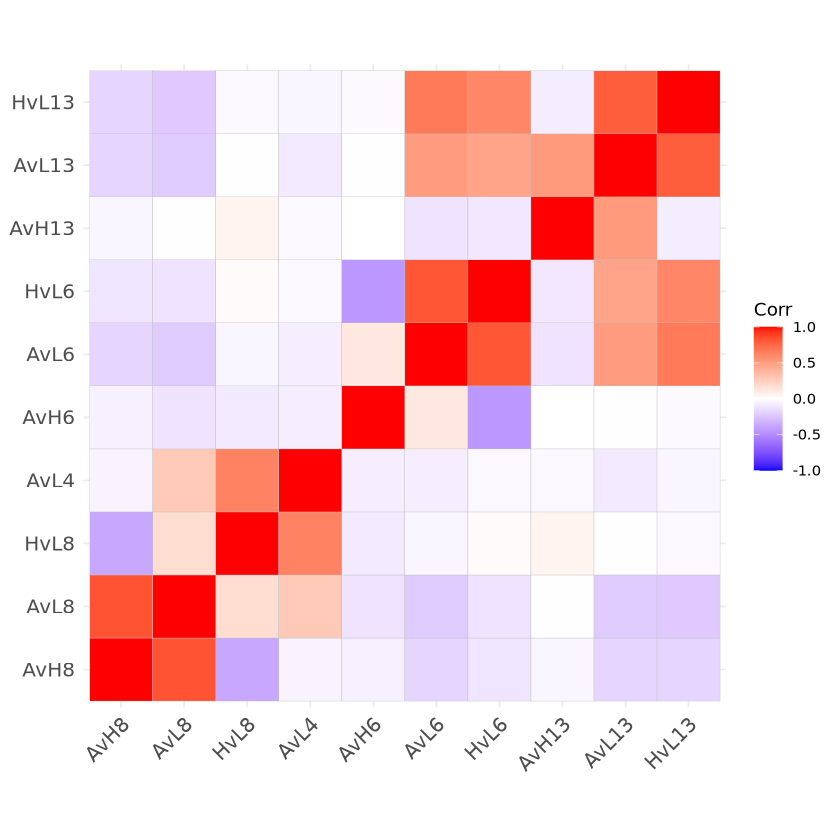

In [313]:
xc=(pivot_longer(lfc_all, cols=(everything()),names_to = 'comp', values_to = 'num'))
#str_split(xc$comp, pattern = '[[:digit:]]+')
corr_matrix=cor(lfc_all)
ggcorrplot(corr_matrix)
ggsave('../figs/cor.AvL8.png', ggcorrplot, 'png')

$sdev
     Comp.1      Comp.2      Comp.3      Comp.4      Comp.5      Comp.6 
0.934883405 0.552395988 0.495837412 0.390104661 0.173480190 0.114349363 
     Comp.7      Comp.8      Comp.9     Comp.10 
0.082672811 0.005095077 0.004609366 0.000000000 

$loadings

Loadings:
      Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8 Comp.9 Comp.10
AvH8   0.310  0.554  0.200         0.195         0.215  0.262  0.416  0.467 
AvL8   0.387  0.228  0.325  0.117  0.198 -0.317  0.400 -0.241 -0.391 -0.411 
HvL8         -0.623  0.196               -0.592  0.225  0.160  0.235  0.280 
AvL4   0.177 -0.478  0.281         0.327  0.705  0.234                      
AvH6                -0.547 -0.548  0.147         0.459 -0.305         0.256 
AvL6  -0.432         0.157 -0.268 -0.259         0.529  0.491        -0.333 
HvL6  -0.413         0.447        -0.326         0.167 -0.540 -0.112  0.418 
AvH13               -0.416  0.684 -0.174  0.129  0.360  0.194 -0.325  0.193 
AvL13 -0.395        -0.172  0.360  

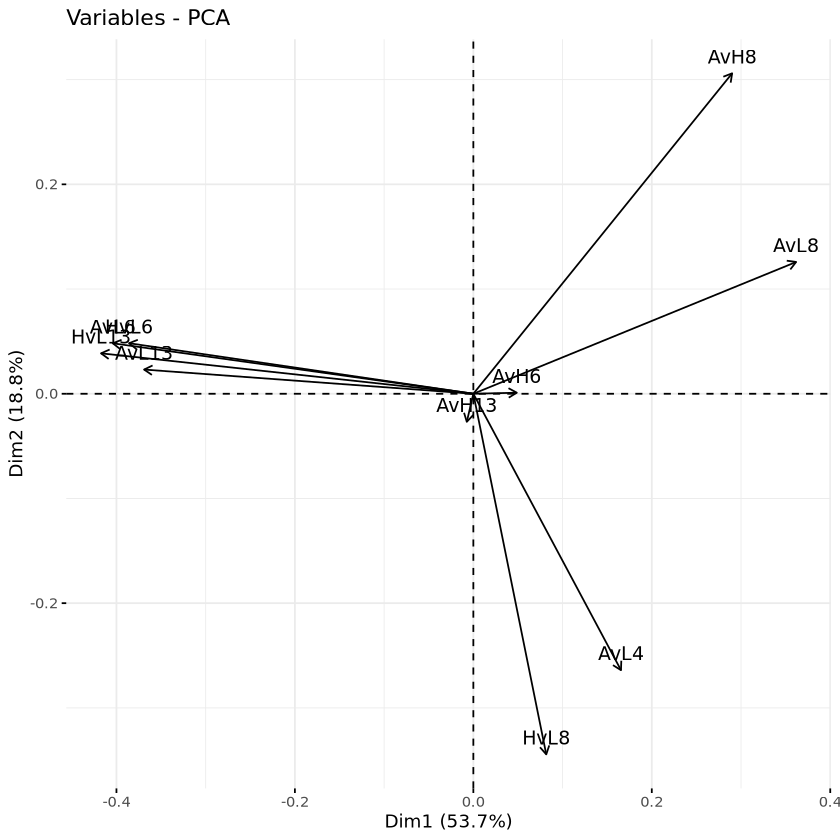

In [77]:
data.pca <- princomp(corr_matrix)
head(data.pca)
fviz_pca_var(data.pca, col.var = "black")

It appears that the cylindrothecca are more different than coccolithophores
## Now I will repeat this using the vsd normalized data. 
We can subset like before, using ko.common

4_add_backA 4_add_backB 4_pFe21_9A 4_pFe21_9B 4_pFe21_9C 8_add_backB
1 5.376857    5.464042    11.857960  11.913769  6.345732    9.897961  
2 3.668991    3.668991     9.575896   9.820268  9.176928   10.672915  
3 4.134146    4.501011    10.229559  10.456547  6.039151    9.829077  
4 4.467910    5.010024    10.445938  10.519360  5.559963   12.279193  
5 4.467910    4.374899     9.577946   9.712434  3.668991   11.858136  
6 6.006051    5.810081    10.687250  10.679385  4.663800    7.356092  
  8_add_backC 8_pFe21_9A 8_pFe19A 8_pFe19B ⋯ 6_pFe21_9C 13_add_backA
1 10.015724   3.697142   3.644625 3.056633 ⋯ 12.911179  3.867407    
2 10.095293   5.318771   4.649164 4.453958 ⋯ 14.785420  6.699776    
3  9.303519   4.678454   3.644625 3.960475 ⋯  9.762367  3.867407    
4 11.885159   6.177225   6.274335 6.546896 ⋯  6.949382  9.544142    
5 11.535942   6.506182   6.274335 6.546896 ⋯ 14.173053  5.365228    
6  7.101334   5.380317   3.644625 4.453958 ⋯  6.056362  8.774727    
  13_add_backB 13_add_backC 13_pFe19A 13_pFe19B 13_pFe19C 13_pFe21_9A
1 3.867407     3.867407     3.867407  3.867407  3.867407  11.598344  
2 6.531340     6.588448     6.738991  6.868471  6.972729  12.943752  
3 3.867407     3.867407     3.867407  3.867407  3.867407   8.885624  
4 9.430251     9.036494     9.336955  9.606227  9.388592  13.036634  
5 5.021105     5.579569     5.834705  5.709094  5.424393   9.060879  
6 8.255955     3.867407     8.442283  7.823419  7.306319   8.625312  
  13_pFe21_9B 13_pFe21_9C
1 11.416377   11.410914  
2 12.787262   12.744767  
3  8.813543    8.451294  
4 13.028527   12.589379  
5  8.967588    8.607814  
6  8.844582    9.538084

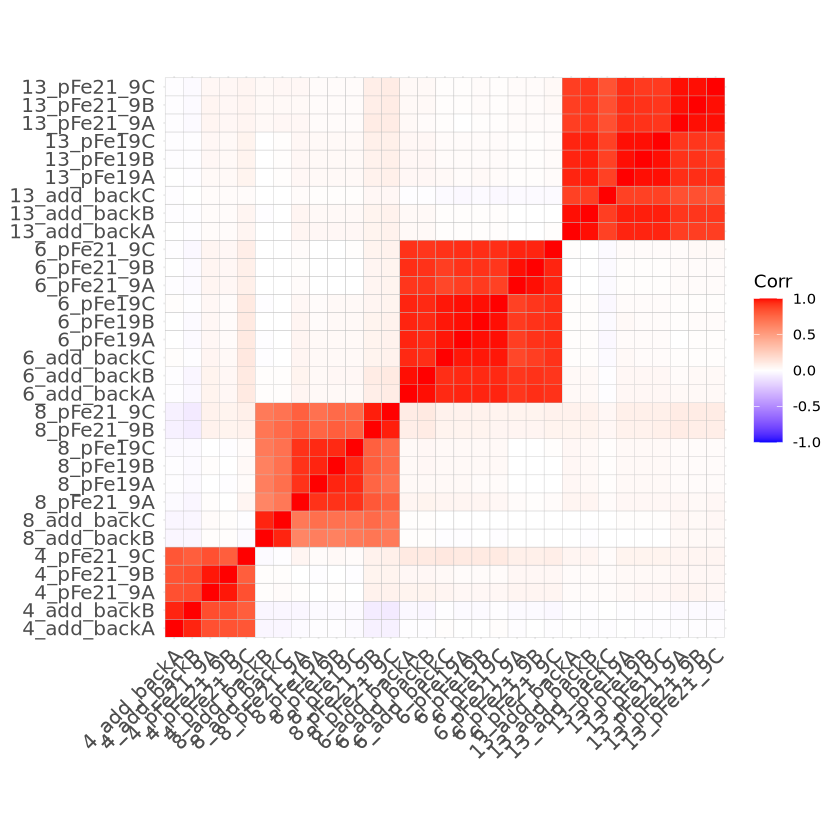

In [58]:
subset.vsd=function(df, org){
    common=filter(df, ko_id %in% ko_common$ko_id)
    colnames(common)=paste(org,colnames(common), sep='_')
    common
}

vsd4.common=subset.vsd(vsd.4.k,'4')
vsd8.common=subset.vsd(vsd.8.k,'8')
vsd6.common=subset.vsd(vsd.6.k,'6')
vsd13.common=subset.vsd(vsd.13.k, '13')
vsd.all=bind_cols(vsd4.common[,-1], vsd8.common[,-1],
                  vsd6.common[,-1],vsd13.common[-1])
head(vsd.all)
corr_vsd=cor(vsd.all)
ggcorrplot(corr_vsd)

In [62]:
vsd.pca <- princomp(corr_vsd)
fviz_contrib(vsd.pca, col.var = "black")


ERROR: Error in match.arg(element): 'arg' should be one of “var”, “ind”


Now this doesn't tell us much, to seperate out the effects of organism and treatment, we need to combine counts per treatment and create a columnn with organism next to it. 

In [101]:
gsea.hvl=read.csv('./de_res_files/core.ko.Hvl.csv')
head(gsea.hvl)
gsea.avl=read.csv('./de_res_files/core.ko.Avl.csv')

gsea.avh=read.csv('./de_res_files/core.ko.Avl.csv')
x = gsea.hvl %>% filter(organism =='C. closterium 8')


ko_id  symbol     name                             
1 K00284  GLU, gltS  glutamate synthase (ferredoxin) 
2 K09838  ZEP, ABA1  zeaxanthin epoxidase            
3 K01649  leuA, IMS  2-isopropylmalate synthase      
4 K03801  lipB       lipoyl(octanoyl) transferase    
5 K15371  GDH2       glutamate dehydrogenase         
6 K15371  GDH2       glutamate dehydrogenase         
  Description                                   organism        treatment
1  Microbial metabolism in diverse environments C. closterium 8 Low Fe   
2  Biosynthesis of secondary metabolites        C. closterium 8 Low Fe   
3  Biosynthesis of amino acids                  C. closterium 8 Low Fe   
4  Biosynthesis of cofactors                    C. closterium 8 Low Fe   
5  Nitrogen metabolism                          E. huxleyi      Low Fe   
6  Microbial metabolism in diverse environments E. huxleyi      Low Fe   
  NES      
1 -2.082380
2 -2.044310
3 -2.031934
4 -1.939036
5 -2.360657
6 -1.800422

ko_id symbol name Description organism treatment NES

# Ternary plots
subset vsd normalized counts for genes in pathway selected. Create a column for each treatment, high low and addback, and a fourth column for group which defines the organism

### Subseet normalized counts

In [6]:
ndf=filter(all.path, path_name=='Riboflavin metabolism')
(arrange(ndf,symbol))
nitrogen=filter(all.path, ko_id %in% c('K00284','K00362','K00366','K00459','K10534','K02575','K15371','K15576','K15577','K15578','K15579',
                                      'K00128','K01624','K03841','K00134','K01895','K00161','K00162','K00138'))
vitamin=filter(all.path, ko_id %in% c('K18278','K14394','K01662','K00788','K00949',
                                     'K00157','K06215','K08681','K00831','K01733',
                                     'K00793','K00794','K02858'))
photo=filter(all.path, ko_id %in%c('K02111','K02115','K02634','K02636','K02639','K02641','K08906','K08903','K02703','K02706','K02716','K02689','K02690','K02692','K08907,','K08911','K08916','K08917'))
carbon=filter(all.path, ko_id %in%c('K01624','K03841','K00814','K14454','K14455','K00026','K00927','K00029','K01601','K01807','K01803',
                                   'K00161','K00162','K00234','K00235','K00236','K00237','K01647','K01676','K01679'))


ko_id  Path     symbol    
1  K14394 map00740 ACP1      
2  K14379 map00740 ACP5      
3  K20884 map00740 FHY       
4  K20860 map00740 FHY1      
5  K00953 map00740 FLAD1     
6  K01078 map00740 PHO       
7  K00861 map00740 RFK, FMN1 
8  K14654 map00740 RIB7, arfC
9  K01515 map00740 nudF      
10 K01497 map00740 ribA, RIB1
11 K02858 map00740 ribB, RIB3
12 K14652 map00740 ribBA     
13 K00793 map00740 ribE, RIB5
14 K00794 map00740 ribH, RIB4
15 K20862 map00740 yigB      
   name                                                                                           
1  low molecular weight phosphotyrosine protein phosphatase [EC:3.1.3.2 3.1.3.48]                 
2  tartrate-resistant acid phosphatase type 5 [EC:3.1.3.2]                                        
3  riboflavin kinase / FMN hydrolase [EC:2.7.1.26 3.1.3.102]                                      
4  FMN hydrolase / 5-amino-6-(5-phospho-D-ribitylamino)uracil phosphatase [EC:3.1.3.102 3.1.3.104]
5  FAD synthetase [EC:2.7.7.2]                                                                    
6  acid phosphatase [EC:3.1.3.2]                                                                  
7  riboflavin kinase [EC:2.7.1.26]                                                                
8  2,5-diamino-6-(ribosylamino)-4(3H)-pyrimidinone 5'-phosphate reductase [EC:1.1.1.302]          
9  ADP-ribose diphosphatase [EC:3.6.1.13 3.6.1.-]                                                 
10 GTP cyclohydrolase II [EC:3.5.4.25]                                                            
11 3,4-dihydroxy 2-butanone 4-phosphate synthase [EC:4.1.99.12]                                   
12 3,4-dihydroxy 2-butanone 4-phosphate synthase / GTP cyclohydrolase II [EC:4.1.99.12 3.5.4.25]  
13 riboflavin synthase [EC:2.5.1.9]                                                               
14 6,7-dimethyl-8-ribityllumazine synthase [EC:2.5.1.78]                                          
15 FMN hydrolase / 5-amino-6-(5-phospho-D-ribitylamino)uracil phosphatase [EC:3.1.3.102 3.1.3.104]
   sub_category          broad_category                  path_name            
1  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
2  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
3  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
4  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
5  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
6  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
7  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
8  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
9  Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
10 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
11 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
12 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
13 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
14 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism
15 Riboflavin metabolism Cofactor and vitamin metabolism Riboflavin metabolism

In [7]:
unique(all.path$path_name)

tern_prep = function(vsd, org, path){
    #path = filter(all.path, path_name==path) %>% select('ko_id')
    tern.df=filter(vsd, ko_id %in% path$ko_id)
    tern.df=pivot_longer(tern.df, cols = !'ko_id', names_to = 'Treatment', values_to = 'Count')
    tern.df$Treatment=str_remove(tern.df$Treatment, 'A|B|C')
    tern.df= tern.df %>% group_by(Treatment, ko_id) %>% summarise('count.m'=mean(Count)) %>% mutate('Organism'=org)
    
    tern.df = pivot_wider(tern.df, names_from = 'Treatment', values_from = 'count.m')
    tern.df                     
                     
}
p6=tern_prep(vsd.6.k, 'G. oceanica', photo)
p8=tern_prep(vsd.8.k, 'C. closterium 8',photo)
p13=tern_prep(vsd.13.k,'E. huxleyi', photo)

c6=tern_prep(vsd.6.k, 'G. oceanica', carbon)
c8=tern_prep(vsd.8.k, 'C. closterium 8',carbon)
c13=tern_prep(vsd.13.k,'E. huxleyi', carbon)

n6=tern_prep(vsd.6.k, 'G. oceanica', nitrogen)
n8=tern_prep(vsd.8.k, 'C. closterium 8',nitrogen)
n13=tern_prep(vsd.13.k,'E. huxleyi', nitrogen)

g6=tern_prep(vsd.6.k, 'G. oceanica', vitamin)
g8=tern_prep(vsd.8.k, 'C. closterium 8',vitamin)
g13=tern_prep(vsd.13.k,'E. huxleyi', vitamin)
#isip6=tern_prep(vsd.6.k, 'G. oceanica', isip.all)
#isip8=tern_prep(vsd.8.k, 'C. closterium 8',isip.all)
#isip13=tern_prep(vsd.13.k,'E. huxleyi', isip.all)
head(g13)
p.tern=bind_rows(p6, p8, p13) %>% group_by(ko_id, Organism) %>% mutate('Path'='Photosynthesis')
c.tern=bind_rows(c6,c8,c13) %>% mutate('Path'='Carbon fixation')
n.tern=bind_rows(n6,n8,n13) %>% mutate('Path'='Nitrogen metabolism')
g.tern=bind_rows(g6,g8,g13) %>% mutate('Path'='Vitamin metabolism')

all.tern=bind_rows(p.tern, c.tern, n.tern,g.tern) %>% group_by(ko_id, Organism, Path)
#isip.tern=bind_rows(isip6, isip8, isip13) %>% group_by(ko_id, Organism)

[1] "Nitrogen metabolism"                                      
 [2] "Glycolysis / Gluconeogenesis"                             
 [3] "Carbon metabolism"                                        
 [4] "Oxidative phosphorylation"                                
 [5] "Riboflavin metabolism"                                    
 [6] "Arginine biosynthesis"                                    
 [7] "ABC transporters"                                         
 [8] "Pantothenate and CoA biosynthesis"                        
 [9] "Citrate cycle (TCA cycle)"                                
[10] "Ubiquinone and other terpenoid-quinone biosynthesis"      
[11] "Calcium signaling pathway"                                
[12] "Porphyrin metabolism"                                     
[13] "Carbon fixation in photosynthetic organisms"              
[14] "Two-component system"                                     
[15] "Photosynthesis"                                           
[16] "Phototransduction"                                        
[17] "Sulfur metabolism"                                        
[18] "Proximal tubule bicarbonate reclamation"                  
[19] "Endocrine and other factor-regulated calcium reabsorption"
[20] "Thiamine metabolism"                                      
[21] "Vitamin B6 metabolism"

`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Tre

ko_id  Organism   add_back  pFe19     pFe21_9  
1 K00157 E. huxleyi  6.149172  5.995000  6.074289
2 K00788 E. huxleyi  4.809754  4.826888  5.152015
3 K00793 E. huxleyi  6.888616  7.007241  6.846558
4 K00794 E. huxleyi  6.400583  6.517941  6.350042
5 K00831 E. huxleyi 10.916007 10.727932 10.110571
6 K00949 E. huxleyi  6.138154  6.297263  6.480141

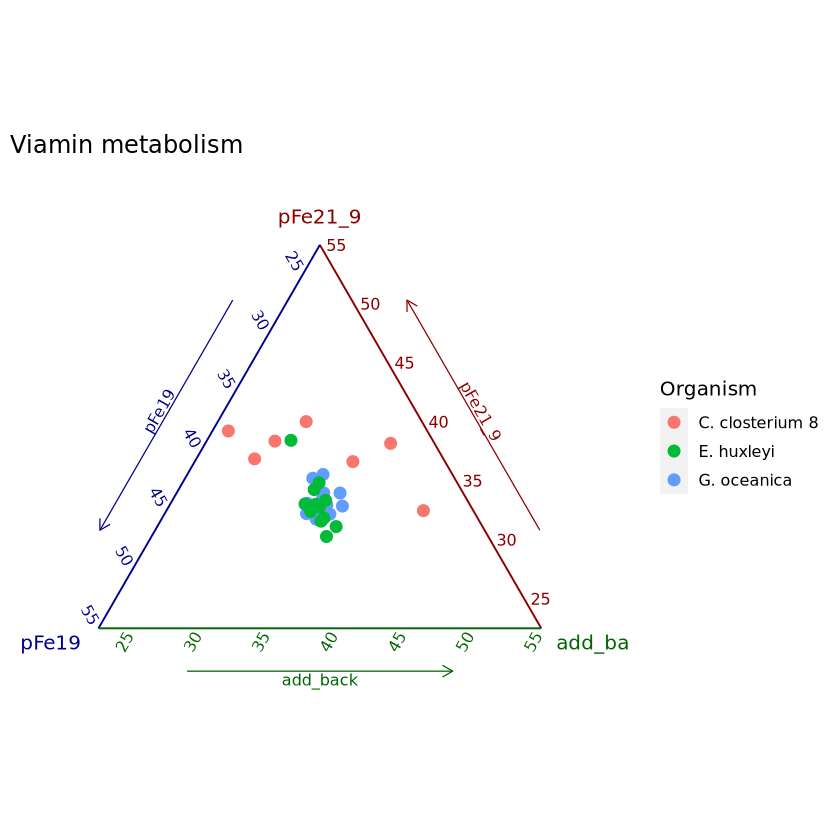

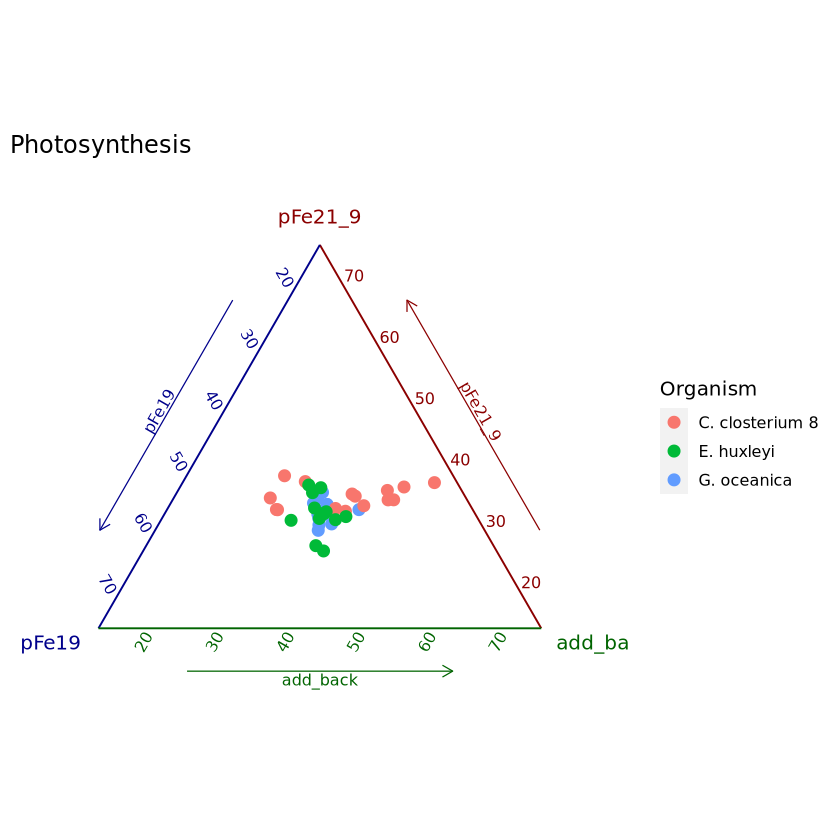

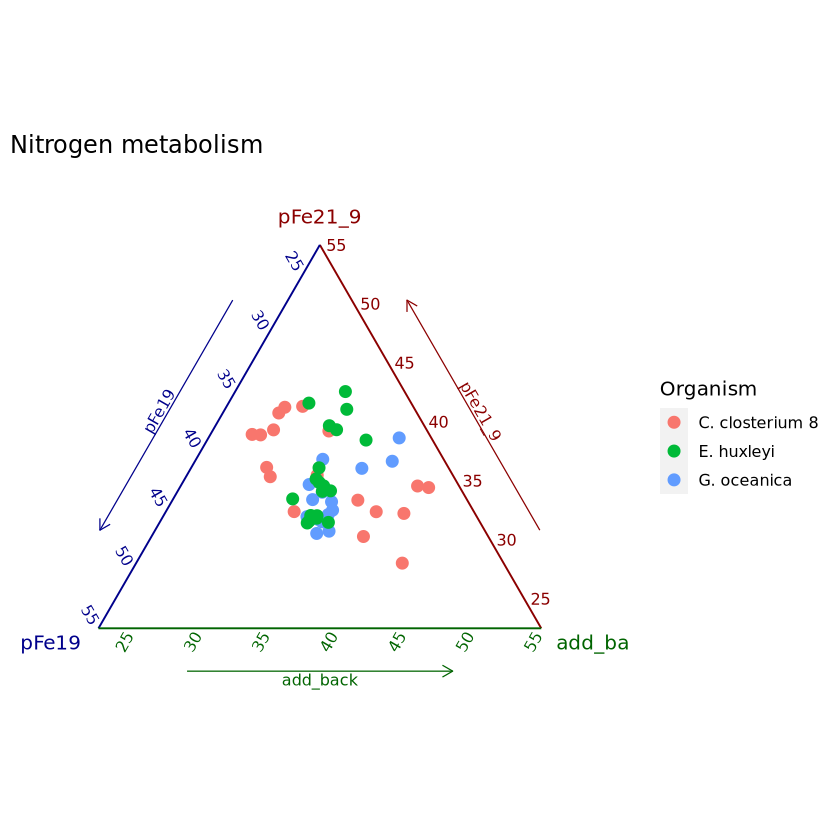

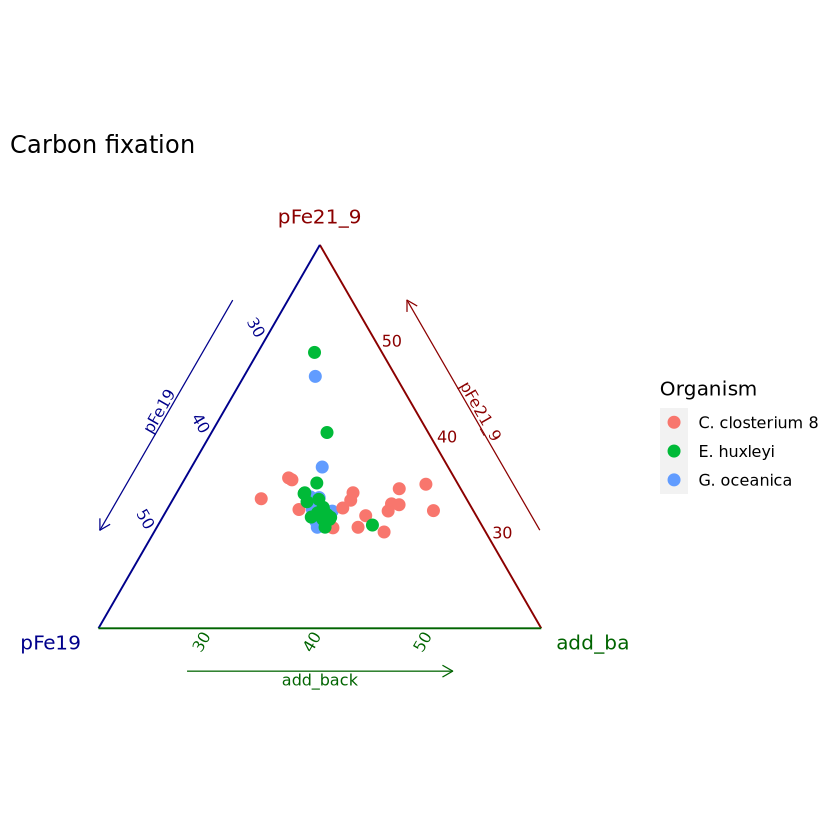

In [9]:
v=ggtern(g.tern, aes(x=pFe19, y=pFe21_9, z=add_back)) + geom_point(size=3, aes(color=Organism))+theme_zoom_center(0.55) + labs(title = 'Viamin metabolism') +
theme_rgbw() + theme_showarrows()+theme_arrowlong()+theme_showgrid_major()
p=ggtern(p.tern, aes(x=pFe19, y=pFe21_9, z=add_back)) + geom_point(size=3, aes(color=Organism))+theme_zoom_center(0.75) + labs(title='Photosynthesis') +
theme_rgbw()+theme_showarrows()+theme_arrowlong()
n=ggtern(n.tern, aes(x=pFe19, y=pFe21_9, z=add_back)) + geom_point(size=3, aes(color=Organism))+theme_zoom_center(0.55) + labs(title='Nitrogen metabolism') + 
theme_rgbw()+theme_showarrows()+theme_arrowlong()
c=ggtern(c.tern, aes(x=pFe19, y=pFe21_9, z=add_back)) + geom_point(size=3, aes(color=Organism))+theme_zoom_center(0.6) + labs(title='Carbon fixation') + 
theme_rgbw()+theme_showarrows()+theme_arrowlong()

v
p
n
c

ggsave('../figs/p.tern.png',p,width = 8,height = 8)
ggsave('../figs/n.tern.png',n,width = 8,height = 8)
ggsave('../figs/c.tern.png',c,width = 8,height = 8)
ggsave('../figs/v.tern.png',v,width = 8,height = 8)

`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.


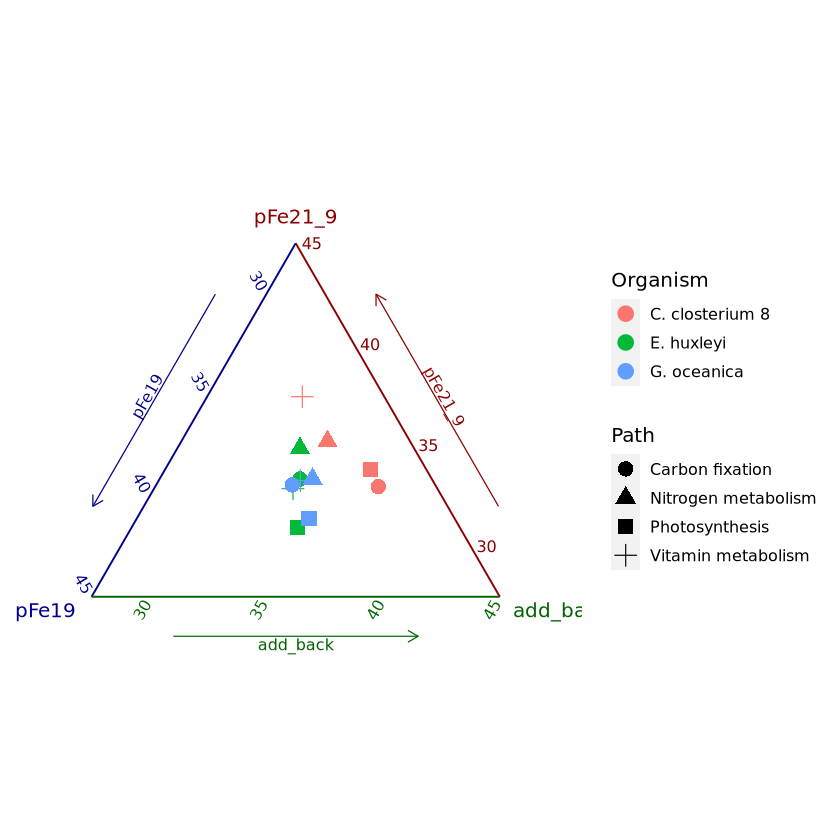

In [10]:
tern.df=pivot_longer(vsd.8.k, cols = !'ko_id', names_to = 'Treatment', values_to = 'Count')
tern.df$Treatment=str_remove(tern.df$Treatment, 'A|B|C')
tern.df= tern.df %>% group_by(Treatment, ko_id) %>% summarise('count.m'= mean(Count)) 
tern.df$count.m=log2(tern.df$count.m)
tern.df = pivot_wider(tern.df, names_from = 'Treatment', values_from = 'count.m')
tern.mat = tern.df %>% column_to_rownames('ko_id') %>% as.matrix
tern.mat <- (tern.mat - rowMeans(tern.mat) ) / rowSds(tern.mat) 
#tern.df = tern.mat %>% as.data.frame() %>% rownames_to_column('ko_id')
tern.df$sum=apply(tern.df[2:4], 1, FUN=sum)
t=data.frame(x=tern.df$add_back, y=tern.df$pFe19, z=tern.df$pFe21_9)
#all.tern=ungroup(all.tern)
all.tern=group_by(all.tern, Organism)
tt=aggregate(all.tern[3:5],by = list(Path=all.tern$Path, Organism=all.tern$Organism),FUN=sum)
a.tern=ggtern(tt, aes(x=pFe19, y=pFe21_9, z=add_back)) + geom_point(size=4,aes(shape=Path, color=Organism))+
 theme_zoom_center(0.45) +theme_rgbw()+theme_showarrows()+theme_arrowlong() + theme_showgrid()
#ggsave('../figs/all.paths.tern.png',a.tern,width = 8,height = 8)
a.tern

# Make table for DE results

In [110]:
avl.df = data.frame('Organism'=c('C. closterium 8', 'C. closterium 4', 'G. oceanica', 'G. huxleyi'), 'Up regulated in iron amendment'=c(lu8), 'Up regulated in low iron'=c())
avl4 = read.csv('./de_res_files/AvL4.k.csv')

sig.4=filter(avl4, padj<0.05)
A4=nrow(filter(avl4, log2FoldChange>0&padj<0.05))
L4=nrow(filter(sig.4, log2FoldChange<0&padj<0.05))
up

ERROR: Error in data.frame(Organism = c("C. closterium 8", "C. closterium 4", : arguments imply differing number of rows: 4, 0


In [3]:
kl=(pivot_longer(vsd.8.k, cols = !'ko_id', names_to = 'Treatment', values_to = 'Count'))

ll=(pivot_wider(kl, names_from = 'ko_id', values_from = 'Count'))
any(is.na(lfc_all[,c(1,4,5)]))


pcr8=prcomp(lfc_all[,c(1,4,5)], center = T, s)
autoplot(pcr8, data=lfc_all, color='organism')
#biplot(pcr8)
create.metadata=function(df,org){
    id=colnames(df)[-1]
    metadata=data.frame('id'=id,'isolate'=org,'treatment'=str_extract(id,'[[:alpha:]]+(19|21_9|_back)'),'rep'=str_extract(id, 'A|B|C'))
    metadata$treatment=str_replace_all(metadata$treatment, c('pFe19'='High_Iron', 'pFe21_9'='Low_Iron','add_back'='Add_Back'))
    rownames(metadata)=metadata$id
    metadata                  
}
meta=create.metadata(vsd.8.k, '08')


xx=vsd.8.k %>% column_to_rownames('ko_id') %>% as.matrix

meta
p=pca(xx, metadata = meta, removeVar = 0.1)
#biplot(p, showLoadings = T)
  biplot(p, showLoadings=T,
    labSize = 5, pointSize = 5)
tri_whole=head(aggregate(vsd.8.k[-1], by = list(ko_id=vsd.8.k$ko_id), sum))
apply(tri_whole[-1],1,FUN=sum)
head(arrange(vsd.8.k,ko_id,desc=F))

ERROR: Error in eval(expr, envir, enclos): object 'vsd.8.k' not found


In [54]:
xx=vsd.8.k  # %>% column_to_rownames('ko_id') %>% as.matrix()
#xx=(t(xx))
xx=pivot_longer(xx,cols=!'ko_id', names_to = 'Treatment', values_to='count') 
head(xx)
xx$Treatment=str_remove(xx$Treatment, pattern = 'A|B|C')
xx=group_by(xx, Treatment, ko_id) %>% summarise(count=sum(count))
xx=pivot_wider(xx, names_from = 'ko_id', values_from = 'count') 
head(xx)
#c('add_backB','add_backC','pFe21_9A','pFe19A','pFe19B','pFe19C','pFe21_9B','pFe21_9C')
meta=data.frame(gene=c(str_extract(colnames(xx), 'K[[:digit:]]{5}')),treatment=c(str_extract(colnames(xx), 'pFe.*|add_.*')))
rownames(meta)=colnames(xx)
head(meta)                               
                               


ko_id  Treatment count    
1 K02636 add_backB  9.897961
2 K02636 add_backC 10.015724
3 K02636 pFe21_9A   3.697142
4 K02636 pFe19A     3.644625
5 K02636 pFe19B     3.056633
6 K02636 pFe19C     3.056633

`summarise()` has grouped output by 'Treatment'. You can override using the `.groups` argument.


Treatment K00001   K00002   K00003    K00006   K00012   K00020   K00021  
1 add_back  12.60813 11.58258  9.371415 13.77084 13.83297 13.44643 12.45676
2 pFe19     15.14885 21.46935 15.479148 18.79776 19.35075 17.72145 17.95121
3 pFe21_9   19.10938 18.26891 17.316813 18.43718 20.63951 20.19071 16.63748
  K00022   K00026   ⋯ K22377   K22378   K22381    K22390   K22395   K22403   
1 13.40607 12.04886 ⋯ 10.61952 17.06981  8.647747 11.77658 13.49237  9.510328
2 14.24377 17.76750 ⋯ 17.22531 27.86863 14.315963 17.37003 19.77044 12.229266
3 16.75375 17.18930 ⋯ 16.61665 25.75695 15.115716 17.56417 14.91229 14.903952
  K22493   K22503   isip_2a  isip_3   
1 15.63491 14.28390 16.25887  8.214855
2 23.30811 21.16936 25.91684 13.366370
3 21.06897 21.30543 32.90678 21.136941

gene   treatment
Treatment NA     NA       
K00001    K00001 NA       
K00002    K00002 NA       
K00003    K00003 NA       
K00006    K00006 NA       
K00012    K00012 NA

ERROR: Error in matrixStats::colVars(x, rows = rows, cols = cols, na.rm = na.rm, : Argument 'x' must be of type logical, integer or numeric, not 'character'.


# Plots from ASLO 2023 conference
To make a heatmap with readable pfam labels that are compresssed, we need to subset here first before running the normalization through vst.

combine counts matrix with pfam datafrme: all cases from the original dds object, adding NAs to missing rows
remove rows where NA values for pfam: all contigs with a pfam hit, NAs removed
compress counts for repeated pfams: summing contig counts with identical pfam hits
create DESeq2 object from matrix, filtering out low read counts
continue to vst normalization and heat mapping

In [71]:
subset.vsd=function(df, org){
    common=filter(df, ko_id %in% ko_common$ko_id)
    add_back=pivot_longer(data = common, 
                 cols = starts_with('add_back'),
                 names_to = 'Organism', 
                 values_to='Add_back')
    if (org != '4'){
    High_Fe=pivot_longer(data = common, 
                 cols = starts_with('pFe19'),
                 names_to = 'Organism', 
                 values_to='High_Fe')
        }
    Low_Fe=pivot_longer(data = common, 
                 cols = starts_with('pFe21_9'),
                 names_to = 'Organism', 
                 values_to='Low_Fe')
    common=bind_cols(add_back,Low_Fe$Low_Fe)
    if (org!='4'){
        common=bind_cols(common, High_Fe$High_Fe)}
    common$Organism=org
    common
    
}
subset.vsd(vsd.4.k, '4')

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 4318) to match `..2` (size 6477).


In [ ]:
#Create new matrix with pfam as rowname and compressed

pfam.counts <- function(countdf, anno){
    #merge dds with selected annotations df by column orfs
    df <- as.data.frame(assay(countdf))%>% tibble::rownames_to_column('orfs')
    df <- left_join(df, anno, 'orfs')

    #returns tibble with removed ORFs(rows) with no annotation 
    df_new <- filter(df, is.na(PFAMs)==FALSE)
    print(paste(nrow(df) - nrow(df_new), " rows removed'", sep=''))

    #returns a tibble of counts summed at contigs with identical pfams
    df_comp <- df_new %>%  
         group_by(PFAMs) %>%  
            summarise(across(where(is.numeric), sum))
   print(paste(nrow(df_new)- nrow(df_comp), " rows removed", sep=''))
    df_comp <- df_comp %>% tibble::column_to_rownames('PFAMs') 
    
 }

counts4_pfam <- pfam.counts(dds4, pfam4)
counts8_pfam <- pfam.counts(dds8, pfam8)
counts6_pfam <- pfam.counts(dds6, pfam6)
counts13_pfam <- pfam.counts(dds13, pfam13)

#--------------------------------------------------------------------------------------------------

#Create DESeq2 data type

de.mat <- function(counts_mat, counts_metadata, n){    
    rownames(counts_metadata) <- colnames(counts_mat)
    dds <- DESeqDataSetFromMatrix( counts_mat,
                            colData=counts_metadata,
                            design=~treatment) 
    
    keep <- rowSums(counts(dds) >=10) >= n #filter out rows with too low expression
    dds <- dds[keep, ]
    dds
}

dds4_pfam <- de.mat(counts4_pfam, counts_metadata4, 2)
dds8_pfam <- de.mat(counts8_pfam, counts_metadata8, 2)
dds6_pfam <- de.mat(counts6_pfam, counts_metadata6, 3)
dds13_pfam <- de.mat(counts13_pfam, counts_metadata13, 3)

#set treatment names and reference levels
levels(dds4_pfam$treatment) <- c("Iron_ammendment", "Low_Iron")
#set Iron ammendment as reference level
dds4_pfam$treatment  <- relevel(dds4_pfam$treatment, "Iron_ammendment")

levels(dds8_pfam$treatment) <- c("Iron_ammendment", "Low_Iron", "High_Iron")
dds8_pfam$treatment  <- relevel(dds8_pfam$treatment,"High_Iron")

levels(dds6_pfam$treatment) <- c("Iron_ammendment", "Low_Iron", "High_Iron")
dds6_pfam$treatment  <- relevel(dds6_pfam$treatment,"High_Iron")

levels(dds13_pfam$treatment) <- c("Iron_ammendment", "Low_Iron", "High_Iron")
dds13_pfam$treatment  <- relevel(dds13_pfam$treatment,"High_Iron")

#--------------------------------------------------------------------------------------------------

#Normalize counts from the compressed pfam data
vsd4_pfam <- vsd.norm(dds4_pfam)
vsd8_pfam <- vsd.norm(dds8_pfam)
vsd6_pfam <- vsd.norm(dds6_pfam)
vsd13_pfam <- vsd.norm(dds13_pfam)

## PCA plot

In [118]:
plot.pca <- function(vsd, org){
    pca_data <- plotPCA(vsd, intgroup=c("treatment","replicate"), returnData = TRUE)
    
    percentVar <- round(100*attr(pca_data, "percentVar"))
   
    group_colors <- c(High_Iron="#E31A1C", Low_Iron="#FDBF6F", Iron_ammendment="#1F78B4")
    
    p <- ggplot(pca_data, aes(PC1, PC2, color=treatment)) +
    geom_point(size=20) +
    labs(
        title=paste(org),
        x=(paste("PC1:", percentVar[1], "% variance")),
        y=(paste("PC2:", percentVar[2], "% variance")),
        color="Treatment")+
    theme_classic(base_size=40) +
    theme(legend.title = element_text(size=30), plot.title=element_text(hjust=0.5))+
    scale_color_manual(values=group_colors,
                       limits=c("High_Iron","Low_Iron","Iron_ammendment")) 
    p
    }

pca4 <- plot.pca(vsd4, "O. Cylindrotheca")
pca8 <- plot.pca(vsd8, "I. Cylindrotheca")
pca6 <- plot.pca(vsd6, "Emiliania huxleyi")
pca13 <- plot.pca(vsd13, "G. oceanica")
pca6
ggsave( "pca4.pdf", pca4, width = 30, height=20)
ggsave( "pca8.pdf", pca8, width = 30, height=20)
ggsave( "pca6.pdf", pca6, width = 30, height=20)
ggsave( "pca13.pdf", pca13, width = 30, height=20)

pca_all <- (pca4| pca8)/(pca6 | pca13)+ plot_layout(guides='collect')
ggsave( "pca_all.pdf", pca_all, width = 30, height=20)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'plotPCA': object 'vsd4' not found


## Gene Clustering on vst
----
Cluster the genes on the heatmap (rows) to find the nodes, or groups of genes associated with one annother. We can identify what these genes are to see if a pattern or larger functional process may be identified. We can identify the rows or genes by Kegg module and see if the clusters group by module, GO process etc.

In [ ]:
add_anno <- function(vsd, pfam){
vsd <- as.data.frame(assay(vsd)) %>% tibble::rownames_to_column('orfs')
vsd <- left_join(vsd, pfam, by='orfs')
vsd$orfs <- as.character(str_replace(vsd$orfs,"_length_[:digit:]+_cov_[:digit:]+\\.[:digit:]+_[:alnum:]+_[:alnum:]+",""))
  vsd
vsd <- unite(vsd, PFAMs, orfs, col="id", sep='_') %>% tibble::column_to_rownames("id")
as.matrix(vsd)
}

new4 <- add_anno(vsd4,pfam4)
new8 <- add_anno(vsd8,pfam8)
new6 <- add_anno(vsd6,pfam6)
new13 <- add_anno(vsd13,pfam13)

#------------------------------------------------------------------------------
anno_pfams <- function(vsd, pfam){
    vsd <- as.data.frame(assay(vsd)) %>% tibble::rownames_to_column('orfs')
    pfams <- pfam[!is.na(pfam$PFAMs),]
    vsd <- vsd %>% filter(orfs %in% pfams$orfs)  
    vsd <- left_join(vsd, pfams, by='orfs')
    vsd$orfs <- as.character(str_replace(vsd$orfs,"_length_[:digit:]+_cov_[:digit:]+\\.[:digit:]+_[:alnum:]+_[:alnum:]+",""))
    vsd
    vsd <- unite(vsd, PFAMs, orfs, col="id", sep='_') %>% tibble::column_to_rownames("id")
    as.matrix(vsd)
}

anno_pfam4 <- anno_pfams(vsd4, pfam4)
anno_pfam8 <- anno_pfams(vsd8, pfam8)
anno_pfam6 <- anno_pfams(vsd6, pfam6)
anno_pfam13 <- anno_pfams(vsd13, pfam13)

In [ ]:
heat <- function(vsd_old, vsd_new){
    top_var <- head(order(rowVars(vsd_new), decreasing = TRUE),50)
    mat_var <- vsd_new[top_var,] #extract count values for the most differentially expressed contigs
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #center each cell in matrix by the avereage across samples (setting scale to true?)
    anno <- as.data.frame(colData(vsd_old)) %>% select("treatment")
    
    colors = list(treatment=c(
            High_Iron = "#E31A1C", 
            Low_Iron = "#FDBF6F", 
            Iron_ammendment = "#1F78B4"))
    
   p <-  pheatmap(mat_var,
             annotation_colors=colors,
             annotation_col = anno, 
             show_colnames = FALSE, 
             show_rownames = TRUE)
}

all.diff4 <- heat(vsd4,new4)
all.diff8 <- heat(vsd8,new8)
all.diff6 <- heat(vsd6,new6)
all.diff13 <- heat(vsd13,new13)
options(repr.plot.width = 12, repr.plot.height = 12)


In [ ]:
heat.mat <- function(vsd){
    top_var <- head(order(rowVars(assay(vsd)), decreasing = TRUE),50)
    mat_var <- assay(vsd)[top_var, ] #extract count values for the most differentially expressed contigs
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #center each cell in matrix by the avereage across samples (setting scale to true?)
    }

heat.map <- function(vsd,org){
    top_var <- head(order(rowVars(assay(vsd)), decreasing = TRUE),10)
    mat_var <- assay(vsd)[top_var, ] #extract count values for the most differentially expressed contigs
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #center each cell in matrix by the avereage across samples (setting scale to true?)
    anno <- as.data.frame(colData(vsd)) %>% select("treatment") 
    colnames(anno) <- c('Treatment')
    colors = list(Treatment=c(
            High_Iron = "#E31A1C", 
            Low_Iron = "#FDBF6F", 
            Iron_ammendment = "#1F78B4"))
    
     myColor <- viridis_pal(option = "B")
    
   p <-  pheatmap(mat_var, annotation_colors=colors, 
                  cellwidth=30, main=org,
                  annotation_col = anno, show_colnames = FALSE, 
                  show_rownames = TRUE, fontsize=24, fontsize_row=20,
                  color=viridis(n=500), border_color="black" )
    }

In [ ]:
#subset genes on interest from normalized counts data (vsd4_pfam etc)
#Ribul_p_3_epim, FA_desaturase, DUF, Glycolytic, FumaraseC,
#Calreticulin, Acyl-CoA_dh, fn3, Sdh_cyt, EF-hand, Aa_trans,  
#NIR_SIR_ferr, AAA, CDC, PsbU, Fasciclin, PA,  Gp, Rieske, 
#F_bP_aldolase, Fer2, CaMKII_AD, Mg-por_mtran, MSP, PSII_BNR
#zf-TAZ, F_bP_aldoase, Photo_RC, PSII_Pbs27


genes <- c("Flavodoxin_1",
           "Cation_efflux",
           "Chloroa_b-bind",
           "Cu-oxidase",
           "Ammonium_transp",
           "CdCA1",
          "Copper-bind",
           "Cytochrom_C",
           "Aminotran_3",
           "CobN-Mg_chel",
          "Fe_bilin_red", 
           "CytB6-F_Fe-S",
          "Fea1",
          "Metallophos",
          "fn3",
          "B12D",
           "PSII",
           "PsaA_PsaB",
           "Metalloenzyme",
           "Photodiest",
           "Cu_amine_oxid", 
           "Fer2",
           "2Fe-2S_Ferredox",
           "Cytochrome_CBB")
length(genes)

In [ ]:
#subsetting genes of interest:

genes_4 <- as.data.frame(assay(vsd4_pfam)) %>% 
                    tibble:: rownames_to_column("pfam")
genes_4 <- filter(genes_4, pfam %in%genes)
genes_4 <- tibble::column_to_rownames(genes_4, 'pfam') 
genes_4 <- as.matrix(genes_4)

genes_8 <- as.data.frame(assay(vsd8_pfam)) %>% 
                    tibble:: rownames_to_column("pfam")
genes_8 <-  filter(genes_8, pfam %in% genes)
genes_8 <- tibble::column_to_rownames(genes_8, 'pfam')  
genes_8 <- as.matrix(genes_8)

genes_6 <- as.data.frame(assay(vsd6_pfam)) %>% 
                    tibble:: rownames_to_column("pfam")
genes_6 <-  filter(genes_6, pfam %in% genes)
genes_6 <- tibble::column_to_rownames(genes_6, 'pfam') 
genes_6 <- as.matrix(genes_6)


genes_13 <- as.data.frame(assay(vsd13_pfam)) %>% 
                    tibble:: rownames_to_column("pfam")
genes_13 <-  filter(genes_13, pfam %in% genes)
genes_13 <- tibble::column_to_rownames(genes_13, 'pfam') 
genes_13 <- as.matrix(genes_13)


In [ ]:
#plotting genes of interest:
gene.heat.map <- function(mat,vsd,org){
    mat <- (mat - rowMeans(mat) ) / rowSds(mat) 
    anno <- as.data.frame(colData(vsd)) %>% select("treatment") 
    colnames(anno) <- c('Treatment')
    colors = list(Treatment=c(
            High_Iron = "#E31A1C", 
            Low_Iron = "#FDBF6F", 
            Iron_ammendment = "#1F78B4"))
    
     myColor <- viridis_pal(option = "B")
    
   p <-  pheatmap(mat, annotation_colors=colors, 
                  cellwidth=30, cellheight=30, main=org,
                  annotation_col = anno, show_colnames = FALSE, 
                  show_rownames = TRUE, fontsize=24, fontsize_row=20,
                  color=viridis(n=500), border_color="black" )
    }


gene13_noname <- gene.heat.map(genes_13, vsd13_pfam, "G. oceanica")
ggsave( "Gene13_no_rnames_hp.pdf", gene13_noname,width=20, height=10 )

decideTests, give -1,0,1 based on if orf was differentially expressed, -1 down reg 1 up reg. Can filter matrix of normalized counts by those not=0 . 

## Clustering with hclust:
hierarchial clustering is a type of unsupervised clustering. This clusters based on correlation that was calculated 
using a pearson correlation. Cluster genes (rowwise) and samples (column wise). use spearman correlation for sample correlation as this give equal weight to highly 

produce modules from clustering using cuttree with k=n, k assigns the number of clusters. We can choose to cluster for the number of samples, or up and down regulation between two treatments. k=2 for high vs low fe. Assign color to modules module.color <- rainbow(length(unique(module.assign)), start = 0.1, end = 0.9)
using rainbow pallet. module.color <- module.color[as.vector(module.assign)]

# Glimma MA plots

The Glimma MDS contains two main components:

1. a plot showing two MDS dimensions, and
2. a plot of the eigenvalues of each dimension

The Glimma MA plot contains two main components:

1. a plot of summary statistics across all genes that have been tested, and
2. a plot of gene expression from individual samples for a given gene

In [12]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.8 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/leq40065/env/r_4.3.1/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] multipanelfigure_2.1.5      PCAtools_2.12.0            
 [3] ggrepel_0.9.4               magick_2.8.0               
 [5] ggfortify_0.4.16            ggtern_3.4.2               
 [7] RCurl_1.98-1.12             circlize_0.4.15            
 [9] f